# Train finetunned SqueezeNet model for multi-label classification

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
import numpy as np

from data_utils import get_id_type_list_for_class, GENERATED_DATA, OUTPUT_PATH, to_set
from training_utils import classification_train as train, classification_validate as validate
from training_utils import exp_decay, step_decay

No data found at D:\vfomin\MyExamples\python\planet_amazon_rainforest\input\test 


Using TensorFlow backend.


In [4]:
from models.squeezenet_multiclassification import get_squeezenet, get_squeezenet2

In [5]:
from sklearn.model_selection import KFold, StratifiedKFold
from data_utils import to_set, equalized_data_classes, unique_tags, train_jpg_ids, TRAIN_ENC_CL_CSV
from data_utils import find_best_weights_file, get_label

In [6]:
from xy_providers import image_label_provider

In [7]:
from keras import backend as K
K.backend(), K.image_data_format()

('tensorflow', 'channels_last')

In [7]:
cnn = get_squeezenet2((256, 256, 3), 17)
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 127, 127, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 127, 127, 64)  0           conv1[0][0]                      
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 63, 63, 64)    0           relu_conv1[0][0]                 
___________________________________________________________________________________________

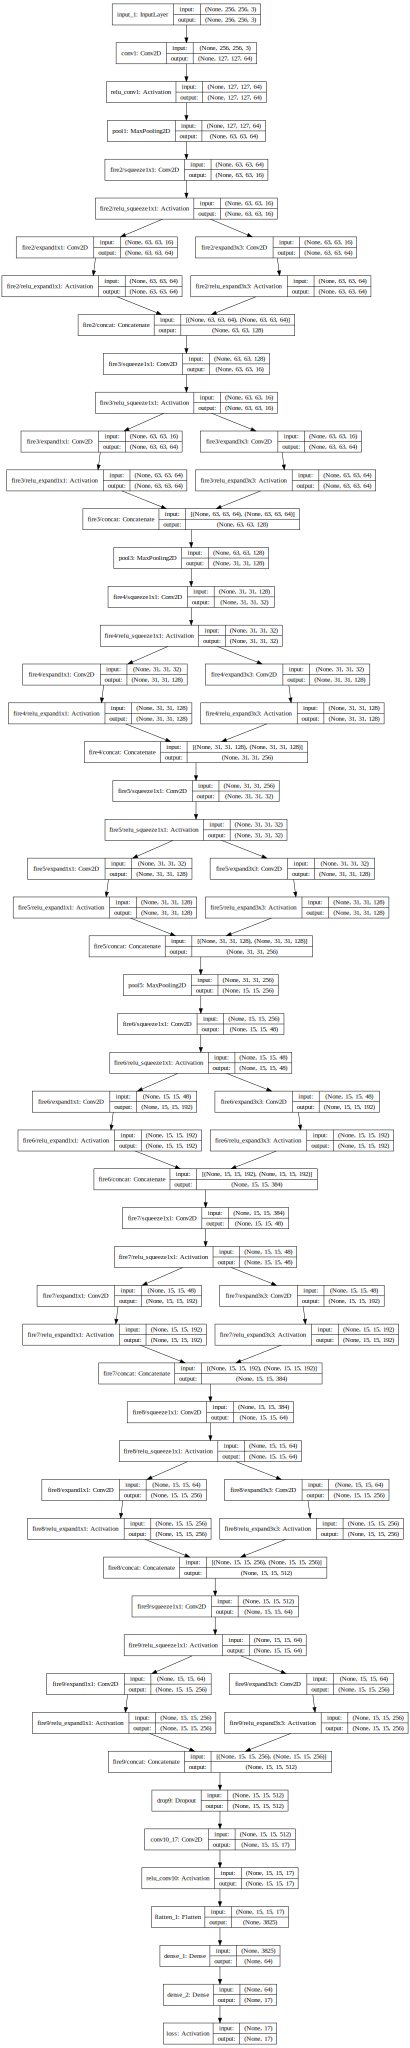

In [8]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(cnn, show_shapes=True).create(prog='dot', format='svg'))

### Define configuration

In [8]:
seed = 2017
np.random.seed(seed)

### !!! Reduced dataset is used !!!

In [21]:
trainval_id_type_list = [(image_id, "Train_jpg") for image_id in train_jpg_ids]

print(len(trainval_id_type_list))

40479


In [13]:
from data_utils import DataCache

try:
    if cache is None:
        cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
        if os.path.exists(cache_filepath):
            print("Load cache from pickle file")
            cache = load_data_cache(cache_filepath)
        else:
            cache = DataCache(10000)
except NameError:
    cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
    if os.path.exists(cache_filepath):
        print("Load cache from pickle file")
        cache = load_data_cache(cache_filepath)
    else:
        cache = DataCache(10000)

In [19]:
params = {
    'seed': seed,
    
    'xy_provider': image_label_provider,
    
    'network': get_squeezenet2,
    'optimizer': 'adadelta',
    'loss': 'categorical_crossentropy',
    'nb_epochs': 30,
    'batch_size': 16,    
    
    'normalize_data': True,
    'normalization': 'vgg',
    
    'image_size': (256, 256),
    
    'lr_kwargs': {
        'lr': 0.01,
        'a': 0.975,
        'init_epoch': 37
    },
    'lr_decay_f': exp_decay,
    
    'cache': cache,
    
#     'class_index': 0,
    
    'pretrained_model': 'load_best',
#     'pretrained_model': os.path.join(GENERATED_DATA, "weights", ""),
        
    'output_path': OUTPUT_PATH,

}

params['save_prefix_template'] = '{cnn_name}_all_classes_fold={fold_index}_seed=%i' % params['seed']
params['input_shape'] = params['image_size'] + (3,)
params['n_classes'] = len(unique_tags)

## Train on all classes

Start CV

In [27]:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=params['seed'])
trainval_id_type_list = np.array(trainval_id_type_list)
for train_index, test_index in kf.split(trainval_id_type_list):        
    train_id_type_list, val_id_type_list = trainval_id_type_list[train_index], trainval_id_type_list[test_index]
    break

In [28]:
train_index[:100], test_index[:100]

(array([  1,   2,   3,   5,   6,   7,   8,   9,  11,  12,  13,  14,  17,
         18,  19,  20,  21,  22,  24,  25,  26,  27,  29,  30,  31,  32,
         33,  34,  35,  36,  37,  38,  42,  43,  44,  45,  47,  48,  49,
         50,  51,  52,  53,  54,  55,  56,  57,  59,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  76,  77,  78,
         80,  81,  84,  85,  86,  87,  88,  90,  91,  92,  93,  94,  95,
         96,  97,  99, 100, 101, 102, 107, 108, 109, 110, 111, 112, 114,
        115, 116, 117, 118, 120, 121, 122, 123, 124]),
 array([  0,   4,  10,  15,  16,  23,  28,  39,  40,  41,  46,  58,  60,
         75,  79,  82,  83,  89,  98, 103, 104, 105, 106, 113, 119, 125,
        131, 132, 134, 135, 137, 138, 151, 161, 167, 168, 170, 171, 172,
        182, 189, 192, 193, 198, 199, 210, 215, 219, 221, 222, 227, 231,
        232, 241, 248, 252, 253, 256, 258, 268, 275, 278, 281, 286, 296,
        299, 305, 307, 311, 320, 321, 323, 325, 332, 334, 335, 339, 3

In [24]:
train_index[:100], test_index[:100]

(array([  1,   2,   3,   5,   6,   7,   8,   9,  11,  12,  13,  14,  17,
         18,  19,  20,  21,  22,  24,  25,  26,  27,  29,  30,  31,  32,
         33,  34,  35,  36,  37,  38,  42,  43,  44,  45,  47,  48,  49,
         50,  51,  52,  53,  54,  55,  56,  57,  59,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  76,  77,  78,
         80,  81,  84,  85,  86,  87,  88,  90,  91,  92,  93,  94,  95,
         96,  97,  99, 100, 101, 102, 107, 108, 109, 110, 111, 112, 114,
        115, 116, 117, 118, 120, 121, 122, 123, 124]),
 array([  0,   4,  10,  15,  16,  23,  28,  39,  40,  41,  46,  58,  60,
         75,  79,  82,  83,  89,  98, 103, 104, 105, 106, 113, 119, 125,
        131, 132, 134, 135, 137, 138, 151, 161, 167, 168, 170, 171, 172,
        182, 189, 192, 193, 198, 199, 210, 215, 219, 221, 222, 227, 231,
        232, 241, 248, 252, 253, 256, 258, 268, 275, 278, 281, 286, 296,
        299, 305, 307, 311, 320, 321, 323, 325, 332, 334, 335, 339, 3

In [20]:
n_folds = 5
val_fold_index = 0
val_fold_indices = [0,]
hists = []

kf = KFold(n_splits=n_folds, shuffle=True, random_state=params['seed'])
trainval_id_type_list = np.array(trainval_id_type_list)
for train_index, test_index in kf.split(trainval_id_type_list):        
    train_id_type_list, val_id_type_list = trainval_id_type_list[train_index], trainval_id_type_list[test_index]
    
    if len(val_fold_indices) > 0:
        if val_fold_index not in val_fold_indices:
            val_fold_index += 1
            continue

    val_fold_index += 1
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)

    print(datetime.now(), len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"

    weights = 'imagenet' if 'pretrained_model' not in params else None
    cnn = params['network'](lr=params['lr_kwargs']['lr'], weights=weights, **params)
    params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)
    print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))
    
    if 'pretrained_model' in params:
        if params['pretrained_model'] == 'load_best':
            weights_files = glob(os.path.join(params['output_path'], "weights", "%s*.h5" % params['save_prefix']))
            assert len(weights_files) > 0, "Failed to load weights"
            best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
            print("Load best loss weights: ", best_weights_filename, best_val_loss)
            cnn.load_weights(best_weights_filename, by_name=True)
        else:
            assert os.path.exist(params['pretrained_model']), "Not found pretrained model"
            print("Load weights: ", params['pretrained_model'])
            cnn.load_weights(params['pretrained_model'], by_name=True)

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(cnn, train_id_type_list, val_id_type_list, **params)    
    if h is None:
        continue
    hists.append(h)



 ---- Validation fold index:  1 / 5
2017-07-05 18:29:18.725560 80 20

 2017-07-05 18:29:19.394560 - Loaded SqueezeNet2 model ...
Load best loss weights:  D:\vfomin\MyExamples\python\planet_amazon_rainforest\output\weights\SqueezeNet2_all_classes_fold=0_seed=2017_37_val_loss=5.1085_val_precision=0.6895_val_recall=0.7962.h5 5.1085

 2017-07-05 18:29:20.042560 - Start training ...

-- Training parameters: 16, 30, 96, 32

-- Fit model
- New Keras API found -

Epoch validation: score = 0.203368 

Epoch 1/30
6/6 [==============================] - 19s - loss: 8.5436 - precision: 0.1686 - recall: 0.5231 - val_loss: 8.5526 - val_precision: 0.1473 - val_recall: 0.4613

Epoch validation: score = 0.265983 

Epoch 2/30
6/6 [==============================] - 17s - loss: 8.0582 - precision: 0.1470 - recall: 0.4940 - val_loss: 8.1557 - val_precision: 0.1466 - val_recall: 0.4643

Epoch validation: score = 0.243225 

Epoch 3/30
6/6 [==============================] - 17s - loss: 8.6823 - precision: 0.1

In [14]:
# output_path = params['output_path'] if 'output_path' in params else OUTPUT_PATH
# weights_path = os.path.join(output_path, "weights")
# weights_filename = os.path.join(weights_path, params['save_prefix'] + "_31_val_loss=6.9420.h5")

# cnn.save_weights(weights_filename)

### Validation all classes

In [31]:
n_runs = 1
n_folds = 5
run_counter = 0
cv_mean_scores = np.zeros((n_runs, n_folds))
val_fold_indices = [0,]

In [32]:
while run_counter < n_runs:    
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)
    val_fold_index = 0
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=params['seed'])
    trainval_id_type_list = np.array(trainval_id_type_list)
    for train_index, test_index in kf.split(trainval_id_type_list):        
        train_id_type_list, val_id_type_list = trainval_id_type_list[train_index], trainval_id_type_list[test_index]

        if len(val_fold_indices) > 0:
            if val_fold_index not in val_fold_indices:
                val_fold_index += 1
                continue

        val_fold_index += 1        
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)

        print(len(train_id_type_list), len(val_id_type_list))
        assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"

        cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'], weights=None)
        params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)        
        print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))        

        weights_files = glob(os.path.join(params['output_path'], "weights", "%s*.h5" % params['save_prefix']))
        assert len(weights_files) > 0, "Failed to load weights"
        best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        cnn.load_weights(best_weights_filename, by_name=True)

        score = validate(cnn, val_id_type_list, verbose=1, **params)   
        cv_mean_scores[run_counter-1, val_fold_index-1] = score
    
print(cv_mean_scores)



 ---- New run :  1 / 1


 ---- Validation fold index:  1 / 5
32383 8096

 2017-07-05 15:40:38.056560 - Loaded SqueezeNet2 model ...
Load best loss weights:  D:\vfomin\MyExamples\python\planet_amazon_rainforest\output\weights\SqueezeNet2_all_classes_fold=0_seed=2017_37_val_loss=5.1085_val_precision=0.6895_val_recall=0.7962.h5 5.1085
Image normalization:  vgg
Image id/type: 35852 Train_jpg | counter= 0
-- Load from RAM
Image id/type: 24566 Train_jpg | counter= 1
-- Load from RAM
Image id/type: 24659 Train_jpg | counter= 2
-- Load from RAM
Image id/type: 32138 Train_jpg | counter= 3
-- Load from RAM
Image id/type: 18567 Train_jpg | counter= 4
-- Load from RAM
Image id/type: 5708 Train_jpg | counter= 5
-- Load from RAM
Image id/type: 11572 Train_jpg | counter= 6
-- Load from RAM
Image id/type: 4039 Train_jpg | counter= 7
-- Load from RAM
Image id/type: 17312 Train_jpg | counter= 8
-- Load from RAM
Image id/type: 25556 Train_jpg | counter= 9
-- Load from RAM
Image id/type: 30821 Train_jpg

Image id/type: 15829 Train_jpg | counter= 128
-- Load from RAM
Image id/type: 31926 Train_jpg | counter= 129
-- Load from RAM
Image id/type: 14455 Train_jpg | counter= 130
-- Load from RAM
Image id/type: 510 Train_jpg | counter= 131
-- Load from RAM
Image id/type: 4635 Train_jpg | counter= 132
-- Load from RAM
Image id/type: 1658 Train_jpg | counter= 133
-- Load from RAM
Image id/type: 32746 Train_jpg | counter= 134
-- Load from RAM
Image id/type: 15214 Train_jpg | counter= 135
-- Load from RAM
Image id/type: 4544 Train_jpg | counter= 136
-- Load from RAM
Image id/type: 22792 Train_jpg | counter= 137
-- Load from RAM
Image id/type: 8592 Train_jpg | counter= 138
-- Load from RAM
Image id/type: 28985 Train_jpg | counter= 139
-- Load from RAM
Image id/type: 23514 Train_jpg | counter= 140
-- Load from RAM
Image id/type: 33075 Train_jpg | counter= 141
-- Load from RAM
Image id/type: 38362 Train_jpg | counter= 142
-- Load from RAM
Image id/type: 9125 Train_jpg | counter= 143
-- Load from RAM

Image id/type: 32810 Train_jpg | counter= 261
-- Load from RAM
Image id/type: 9104 Train_jpg | counter= 262
-- Load from RAM
Image id/type: 16241 Train_jpg | counter= 263
-- Load from RAM
Image id/type: 33941 Train_jpg | counter= 264
-- Load from RAM
Image id/type: 39748 Train_jpg | counter= 265
-- Load from RAM
Image id/type: 22030 Train_jpg | counter= 266
-- Load from RAM
Image id/type: 36841 Train_jpg | counter= 267
-- Load from RAM
Image id/type: 19448 Train_jpg | counter= 268
-- Load from RAM
Image id/type: 35406 Train_jpg | counter= 269
-- Load from RAM
Image id/type: 1884 Train_jpg | counter= 270
-- Load from RAM
Image id/type: 9178 Train_jpg | counter= 271
-- Load from RAM
Image id/type: 36643 Train_jpg | counter= 272
-- Load from RAM
Image id/type: 15542 Train_jpg | counter= 273
-- Load from RAM
Image id/type: 11568 Train_jpg | counter= 274
-- Load from RAM
Image id/type: 36310 Train_jpg | counter= 275
-- Load from RAM
Image id/type: 12234 Train_jpg | counter= 276
-- Load from

Image id/type: 29216 Train_jpg | counter= 392
-- Load from RAM
Image id/type: 27797 Train_jpg | counter= 393
-- Load from RAM
Image id/type: 15532 Train_jpg | counter= 394
-- Load from RAM
Image id/type: 341 Train_jpg | counter= 395
-- Load from RAM
Image id/type: 17662 Train_jpg | counter= 396
-- Load from RAM
Image id/type: 5696 Train_jpg | counter= 397
-- Load from RAM
Image id/type: 28976 Train_jpg | counter= 398
-- Load from RAM
Image id/type: 15368 Train_jpg | counter= 399
-- Load from RAM
Image id/type: 10909 Train_jpg | counter= 400
-- Load from RAM
Image id/type: 31084 Train_jpg | counter= 401
-- Load from RAM
Image id/type: 28282 Train_jpg | counter= 402
-- Load from RAM
Image id/type: 22227 Train_jpg | counter= 403
-- Load from RAM
Image id/type: 39505 Train_jpg | counter= 404
-- Load from RAM
Image id/type: 13963 Train_jpg | counter= 405
-- Load from RAM
Image id/type: 17363 Train_jpg | counter= 406
-- Load from RAM
Image id/type: 286 Train_jpg | counter= 407
-- Load from R

Image id/type: 3592 Train_jpg | counter= 523
-- Load from RAM
Image id/type: 32752 Train_jpg | counter= 524
-- Load from RAM
Image id/type: 28870 Train_jpg | counter= 525
-- Load from RAM
Image id/type: 2457 Train_jpg | counter= 526
-- Load from RAM
Image id/type: 23820 Train_jpg | counter= 527
-- Load from RAM
Image id/type: 27016 Train_jpg | counter= 528
-- Load from RAM
Image id/type: 7942 Train_jpg | counter= 529
-- Load from RAM
Image id/type: 26769 Train_jpg | counter= 530
-- Load from RAM
Image id/type: 16064 Train_jpg | counter= 531
-- Load from RAM
Image id/type: 14744 Train_jpg | counter= 532
-- Load from RAM
Image id/type: 2343 Train_jpg | counter= 533
-- Load from RAM
Image id/type: 27011 Train_jpg | counter= 534
-- Load from RAM
Image id/type: 3458 Train_jpg | counter= 535
-- Load from RAM
Image id/type: 28733 Train_jpg | counter= 536
-- Load from RAM
Image id/type: 26144 Train_jpg | counter= 537
-- Load from RAM
Image id/type: 10301 Train_jpg | counter= 538
-- Load from R

Image id/type: 17215 Train_jpg | counter= 654
-- Load from RAM
Image id/type: 28195 Train_jpg | counter= 655
-- Load from RAM
Image id/type: 4839 Train_jpg | counter= 656
-- Load from RAM
Image id/type: 6457 Train_jpg | counter= 657
-- Load from RAM
Image id/type: 9578 Train_jpg | counter= 658
-- Load from RAM
Image id/type: 14620 Train_jpg | counter= 659
-- Load from RAM
Image id/type: 10091 Train_jpg | counter= 660
-- Load from RAM
Image id/type: 32310 Train_jpg | counter= 661
-- Load from RAM
Image id/type: 19424 Train_jpg | counter= 662
-- Load from RAM
Image id/type: 3867 Train_jpg | counter= 663
-- Load from RAM
Image id/type: 6576 Train_jpg | counter= 664
-- Load from RAM
Image id/type: 38653 Train_jpg | counter= 665
-- Load from RAM
Image id/type: 31774 Train_jpg | counter= 666
-- Load from RAM
Image id/type: 37974 Train_jpg | counter= 667
-- Load from RAM
Image id/type: 4077 Train_jpg | counter= 668
-- Load from RAM
Image id/type: 23596 Train_jpg | counter= 669
-- Load from RA

Image id/type: 35643 Train_jpg | counter= 790
-- Load from RAM
Image id/type: 15402 Train_jpg | counter= 791
-- Load from RAM
Image id/type: 20975 Train_jpg | counter= 792
-- Load from RAM
Image id/type: 4841 Train_jpg | counter= 793
-- Load from RAM
Image id/type: 28494 Train_jpg | counter= 794
-- Load from RAM
Image id/type: 34963 Train_jpg | counter= 795
-- Load from RAM
Image id/type: 16061 Train_jpg | counter= 796
-- Load from RAM
Image id/type: 21797 Train_jpg | counter= 797
-- Load from RAM
Image id/type: 2391 Train_jpg | counter= 798
-- Load from RAM
Image id/type: 5840 Train_jpg | counter= 799
-- Load from RAM
Image id/type: 21956 Train_jpg | counter= 800
-- Load from RAM
Image id/type: 34150 Train_jpg | counter= 801
-- Load from RAM
Image id/type: 21235 Train_jpg | counter= 802
-- Load from RAM
Image id/type: 16811 Train_jpg | counter= 803
-- Load from RAM
Image id/type: 5837 Train_jpg | counter= 804
-- Load from RAM
Image id/type: 17955 Train_jpg | counter= 805
-- Load from 

Image id/type: 19582 Train_jpg | counter= 925
-- Load from RAM
Image id/type: 1854 Train_jpg | counter= 926
-- Load from RAM
Image id/type: 12618 Train_jpg | counter= 927
-- Load from RAM
Image id/type: 16974 Train_jpg | counter= 928
-- Load from RAM
Image id/type: 24994 Train_jpg | counter= 929
-- Load from RAM
Image id/type: 646 Train_jpg | counter= 930
-- Load from RAM
Image id/type: 32971 Train_jpg | counter= 931
-- Load from RAM
Image id/type: 17930 Train_jpg | counter= 932
-- Load from RAM
Image id/type: 14157 Train_jpg | counter= 933
-- Load from RAM
Image id/type: 10132 Train_jpg | counter= 934
-- Load from RAM
Image id/type: 3526 Train_jpg | counter= 935
-- Load from RAM
Image id/type: 27087 Train_jpg | counter= 936
-- Load from RAM
Image id/type: 10115 Train_jpg | counter= 937
-- Load from RAM
Image id/type: 31983 Train_jpg | counter= 938
-- Load from RAM
Image id/type: 14270 Train_jpg | counter= 939
-- Load from RAM
Image id/type: 13095 Train_jpg | counter= 940
-- Load from 

Image id/type: 20101 Train_jpg | counter= 1056
-- Load from RAM
Image id/type: 10796 Train_jpg | counter= 1057
-- Load from RAM
Image id/type: 15256 Train_jpg | counter= 1058
-- Load from RAM
Image id/type: 35433 Train_jpg | counter= 1059
-- Load from RAM
Image id/type: 16931 Train_jpg | counter= 1060
-- Load from RAM
Image id/type: 34041 Train_jpg | counter= 1061
-- Load from RAM
Image id/type: 9435 Train_jpg | counter= 1062
-- Load from RAM
Image id/type: 35729 Train_jpg | counter= 1063
-- Load from RAM
Image id/type: 8430 Train_jpg | counter= 1064
-- Load from RAM
Image id/type: 9128 Train_jpg | counter= 1065
-- Load from RAM
Image id/type: 36120 Train_jpg | counter= 1066
-- Load from RAM
Image id/type: 31566 Train_jpg | counter= 1067
-- Load from RAM
Image id/type: 26310 Train_jpg | counter= 1068
-- Load from RAM
Image id/type: 34436 Train_jpg | counter= 1069
-- Load from RAM
Image id/type: 28476 Train_jpg | counter= 1070
-- Load from RAM
Image id/type: 8113 Train_jpg | counter= 10

Image id/type: 13247 Train_jpg | counter= 1191
-- Load from RAM
Image id/type: 29948 Train_jpg | counter= 1192
-- Load from RAM
Image id/type: 11253 Train_jpg | counter= 1193
-- Load from RAM
Image id/type: 17852 Train_jpg | counter= 1194
-- Load from RAM
Image id/type: 28555 Train_jpg | counter= 1195
-- Load from RAM
Image id/type: 19742 Train_jpg | counter= 1196
-- Load from RAM
Image id/type: 11926 Train_jpg | counter= 1197
-- Load from RAM
Image id/type: 38074 Train_jpg | counter= 1198
-- Load from RAM
Image id/type: 16843 Train_jpg | counter= 1199
-- Load from RAM
Image id/type: 26299 Train_jpg | counter= 1200
-- Load from RAM
Image id/type: 11877 Train_jpg | counter= 1201
-- Load from RAM
Image id/type: 38675 Train_jpg | counter= 1202
-- Load from RAM
Image id/type: 20065 Train_jpg | counter= 1203
-- Load from RAM
Image id/type: 21366 Train_jpg | counter= 1204
-- Load from RAM
Image id/type: 32603 Train_jpg | counter= 1205
-- Load from RAM
Image id/type: 26376 Train_jpg | counter

Image id/type: 7373 Train_jpg | counter= 1325
-- Load from RAM
Image id/type: 10708 Train_jpg | counter= 1326
-- Load from RAM
Image id/type: 19126 Train_jpg | counter= 1327
-- Load from RAM
Image id/type: 19825 Train_jpg | counter= 1328
-- Load from RAM
Image id/type: 20526 Train_jpg | counter= 1329
-- Load from RAM
Image id/type: 21759 Train_jpg | counter= 1330
-- Load from RAM
Image id/type: 4177 Train_jpg | counter= 1331
-- Load from RAM
Image id/type: 25395 Train_jpg | counter= 1332
-- Load from RAM
Image id/type: 16523 Train_jpg | counter= 1333
-- Load from RAM
Image id/type: 11256 Train_jpg | counter= 1334
-- Load from RAM
Image id/type: 2085 Train_jpg | counter= 1335
-- Load from RAM
Image id/type: 38986 Train_jpg | counter= 1336
-- Load from RAM
Image id/type: 28903 Train_jpg | counter= 1337
-- Load from RAM
Image id/type: 27874 Train_jpg | counter= 1338
-- Load from RAM
Image id/type: 17221 Train_jpg | counter= 1339
-- Load from RAM
Image id/type: 1101 Train_jpg | counter= 13

Image id/type: 17856 Train_jpg | counter= 1456
-- Load from RAM
Image id/type: 28794 Train_jpg | counter= 1457
-- Load from RAM
Image id/type: 25057 Train_jpg | counter= 1458
-- Load from RAM
Image id/type: 3115 Train_jpg | counter= 1459
-- Load from RAM
Image id/type: 8041 Train_jpg | counter= 1460
-- Load from RAM
Image id/type: 20495 Train_jpg | counter= 1461
-- Load from RAM
Image id/type: 16202 Train_jpg | counter= 1462
-- Load from RAM
Image id/type: 33329 Train_jpg | counter= 1463
-- Load from RAM
Image id/type: 24993 Train_jpg | counter= 1464
-- Load from RAM
Image id/type: 35265 Train_jpg | counter= 1465
-- Load from RAM
Image id/type: 36601 Train_jpg | counter= 1466
-- Load from RAM
Image id/type: 24762 Train_jpg | counter= 1467
-- Load from RAM
Image id/type: 34861 Train_jpg | counter= 1468
-- Load from RAM
Image id/type: 27227 Train_jpg | counter= 1469
-- Load from RAM
Image id/type: 28833 Train_jpg | counter= 1470
-- Load from RAM
Image id/type: 18954 Train_jpg | counter= 

Image id/type: 20616 Train_jpg | counter= 1588
-- Load from RAM
Image id/type: 29496 Train_jpg | counter= 1589
-- Load from RAM
Image id/type: 3713 Train_jpg | counter= 1590
-- Load from RAM
Image id/type: 27897 Train_jpg | counter= 1591
-- Load from RAM
Image id/type: 29712 Train_jpg | counter= 1592
-- Load from RAM
Image id/type: 30918 Train_jpg | counter= 1593
-- Load from RAM
Image id/type: 33357 Train_jpg | counter= 1594
-- Load from RAM
Image id/type: 18124 Train_jpg | counter= 1595
-- Load from RAM
Image id/type: 31174 Train_jpg | counter= 1596
-- Load from RAM
Image id/type: 21040 Train_jpg | counter= 1597
-- Load from RAM
Image id/type: 34628 Train_jpg | counter= 1598
-- Load from RAM
Image id/type: 16466 Train_jpg | counter= 1599
-- Load from RAM
Image id/type: 33108 Train_jpg | counter= 1600
-- Load from RAM
Image id/type: 38654 Train_jpg | counter= 1601
-- Load from RAM
Image id/type: 39674 Train_jpg | counter= 1602
-- Load from RAM
Image id/type: 15203 Train_jpg | counter=

Image id/type: 268 Train_jpg | counter= 1718
-- Load from RAM
Image id/type: 35427 Train_jpg | counter= 1719
-- Load from RAM
Image id/type: 3944 Train_jpg | counter= 1720
-- Load from RAM
Image id/type: 34780 Train_jpg | counter= 1721
-- Load from RAM
Image id/type: 8194 Train_jpg | counter= 1722
-- Load from RAM
Image id/type: 10359 Train_jpg | counter= 1723
-- Load from RAM
Image id/type: 10010 Train_jpg | counter= 1724
-- Load from RAM
Image id/type: 36631 Train_jpg | counter= 1725
-- Load from RAM
Image id/type: 584 Train_jpg | counter= 1726
-- Load from RAM
Image id/type: 18196 Train_jpg | counter= 1727
-- Load from RAM
Image id/type: 15524 Train_jpg | counter= 1728
-- Load from RAM
Image id/type: 4835 Train_jpg | counter= 1729
-- Load from RAM
Image id/type: 7730 Train_jpg | counter= 1730
-- Load from RAM
Image id/type: 27872 Train_jpg | counter= 1731
-- Load from RAM
Image id/type: 11137 Train_jpg | counter= 1732
-- Load from RAM
Image id/type: 5595 Train_jpg | counter= 1733
--

Image id/type: 16599 Train_jpg | counter= 1852
-- Load from RAM
Image id/type: 39104 Train_jpg | counter= 1853
-- Load from RAM
Image id/type: 4612 Train_jpg | counter= 1854
-- Load from RAM
Image id/type: 25462 Train_jpg | counter= 1855
-- Load from RAM
Image id/type: 13126 Train_jpg | counter= 1856
-- Load from RAM
Image id/type: 20125 Train_jpg | counter= 1857
-- Load from RAM
Image id/type: 3460 Train_jpg | counter= 1858
-- Load from RAM
Image id/type: 18205 Train_jpg | counter= 1859
-- Load from RAM
Image id/type: 12781 Train_jpg | counter= 1860
-- Load from RAM
Image id/type: 10823 Train_jpg | counter= 1861
-- Load from RAM
Image id/type: 35956 Train_jpg | counter= 1862
-- Load from RAM
Image id/type: 4315 Train_jpg | counter= 1863
-- Load from RAM
Image id/type: 28709 Train_jpg | counter= 1864
-- Load from RAM
Image id/type: 5038 Train_jpg | counter= 1865
-- Load from RAM
Image id/type: 39113 Train_jpg | counter= 1866
-- Load from RAM
Image id/type: 29456 Train_jpg | counter= 18

Image id/type: 36649 Train_jpg | counter= 1984
-- Load from RAM
Image id/type: 21323 Train_jpg | counter= 1985
-- Load from RAM
Image id/type: 17286 Train_jpg | counter= 1986
-- Load from RAM
Image id/type: 2075 Train_jpg | counter= 1987
-- Load from RAM
Image id/type: 11423 Train_jpg | counter= 1988
-- Load from RAM
Image id/type: 523 Train_jpg | counter= 1989
-- Load from RAM
Image id/type: 37619 Train_jpg | counter= 1990
-- Load from RAM
Image id/type: 23077 Train_jpg | counter= 1991
-- Load from RAM
Image id/type: 9530 Train_jpg | counter= 1992
-- Load from RAM
Image id/type: 33201 Train_jpg | counter= 1993
-- Load from RAM
Image id/type: 30673 Train_jpg | counter= 1994
-- Load from RAM
Image id/type: 9651 Train_jpg | counter= 1995
-- Load from RAM
Image id/type: 5421 Train_jpg | counter= 1996
-- Load from RAM
Image id/type: 40001 Train_jpg | counter= 1997
-- Load from RAM
Image id/type: 39201 Train_jpg | counter= 1998
-- Load from RAM
Image id/type: 28348 Train_jpg | counter= 1999

Image id/type: 35306 Train_jpg | counter= 2118
-- Load from RAM
Image id/type: 38792 Train_jpg | counter= 2119
-- Load from RAM
Image id/type: 2057 Train_jpg | counter= 2120
-- Load from RAM
Image id/type: 7994 Train_jpg | counter= 2121
-- Load from RAM
Image id/type: 40281 Train_jpg | counter= 2122
-- Load from RAM
Image id/type: 16862 Train_jpg | counter= 2123
-- Load from RAM
Image id/type: 28140 Train_jpg | counter= 2124
-- Load from RAM
Image id/type: 10422 Train_jpg | counter= 2125
-- Load from RAM
Image id/type: 34240 Train_jpg | counter= 2126
-- Load from RAM
Image id/type: 24248 Train_jpg | counter= 2127
-- Load from RAM
Image id/type: 39024 Train_jpg | counter= 2128
-- Load from RAM
Image id/type: 38811 Train_jpg | counter= 2129
-- Load from RAM
Image id/type: 16594 Train_jpg | counter= 2130
-- Load from RAM
Image id/type: 18867 Train_jpg | counter= 2131
-- Load from RAM
Image id/type: 24033 Train_jpg | counter= 2132
-- Load from RAM
Image id/type: 22593 Train_jpg | counter= 

Image id/type: 15246 Train_jpg | counter= 2249
-- Load from RAM
Image id/type: 6903 Train_jpg | counter= 2250
-- Load from RAM
Image id/type: 25979 Train_jpg | counter= 2251
-- Load from RAM
Image id/type: 16216 Train_jpg | counter= 2252
-- Load from RAM
Image id/type: 5375 Train_jpg | counter= 2253
-- Load from RAM
Image id/type: 22566 Train_jpg | counter= 2254
-- Load from RAM
Image id/type: 5694 Train_jpg | counter= 2255
-- Load from RAM
Image id/type: 191 Train_jpg | counter= 2256
-- Load from RAM
Image id/type: 7127 Train_jpg | counter= 2257
-- Load from RAM
Image id/type: 39602 Train_jpg | counter= 2258
-- Load from RAM
Image id/type: 33437 Train_jpg | counter= 2259
-- Load from RAM
Image id/type: 20465 Train_jpg | counter= 2260
-- Load from RAM
Image id/type: 3004 Train_jpg | counter= 2261
-- Load from RAM
Image id/type: 19973 Train_jpg | counter= 2262
-- Load from RAM
Image id/type: 28884 Train_jpg | counter= 2263
-- Load from RAM
Image id/type: 24657 Train_jpg | counter= 2264


Image id/type: 544 Train_jpg | counter= 2380
-- Load from RAM
Image id/type: 35164 Train_jpg | counter= 2381
-- Load from RAM
Image id/type: 13008 Train_jpg | counter= 2382
-- Load from RAM
Image id/type: 6646 Train_jpg | counter= 2383
-- Load from RAM
Image id/type: 32787 Train_jpg | counter= 2384
-- Load from RAM
Image id/type: 2024 Train_jpg | counter= 2385
-- Load from RAM
Image id/type: 14988 Train_jpg | counter= 2386
-- Load from RAM
Image id/type: 33916 Train_jpg | counter= 2387
-- Load from RAM
Image id/type: 27883 Train_jpg | counter= 2388
-- Load from RAM
Image id/type: 678 Train_jpg | counter= 2389
-- Load from RAM
Image id/type: 4483 Train_jpg | counter= 2390
-- Load from RAM
Image id/type: 14930 Train_jpg | counter= 2391
-- Load from RAM
Image id/type: 35934 Train_jpg | counter= 2392
-- Load from RAM
Image id/type: 13232 Train_jpg | counter= 2393
-- Load from RAM
Image id/type: 39653 Train_jpg | counter= 2394
-- Load from RAM
Image id/type: 38492 Train_jpg | counter= 2395


Image id/type: 289 Train_jpg | counter= 2510
-- Load from RAM
Image id/type: 38843 Train_jpg | counter= 2511
-- Load from RAM
Image id/type: 20226 Train_jpg | counter= 2512
-- Load from RAM
Image id/type: 21506 Train_jpg | counter= 2513
-- Load from RAM
Image id/type: 8437 Train_jpg | counter= 2514
-- Load from RAM
Image id/type: 30103 Train_jpg | counter= 2515
-- Load from RAM
Image id/type: 27523 Train_jpg | counter= 2516
-- Load from RAM
Image id/type: 34383 Train_jpg | counter= 2517
-- Load from RAM
Image id/type: 36893 Train_jpg | counter= 2518
-- Load from RAM
Image id/type: 26267 Train_jpg | counter= 2519
-- Load from RAM
Image id/type: 16812 Train_jpg | counter= 2520
-- Load from RAM
Image id/type: 14381 Train_jpg | counter= 2521
-- Load from RAM
Image id/type: 8851 Train_jpg | counter= 2522
-- Load from RAM
Image id/type: 21332 Train_jpg | counter= 2523
-- Load from RAM
Image id/type: 17637 Train_jpg | counter= 2524
-- Load from RAM
Image id/type: 16387 Train_jpg | counter= 25

Image id/type: 30463 Train_jpg | counter= 2640
-- Load from RAM
Image id/type: 33282 Train_jpg | counter= 2641
-- Load from RAM
Image id/type: 15554 Train_jpg | counter= 2642
-- Load from RAM
Image id/type: 19529 Train_jpg | counter= 2643
-- Load from RAM
Image id/type: 11329 Train_jpg | counter= 2644
-- Load from RAM
Image id/type: 14636 Train_jpg | counter= 2645
-- Load from RAM
Image id/type: 1713 Train_jpg | counter= 2646
-- Load from RAM
Image id/type: 13194 Train_jpg | counter= 2647
-- Load from RAM
Image id/type: 9757 Train_jpg | counter= 2648
-- Load from RAM
Image id/type: 27551 Train_jpg | counter= 2649
-- Load from RAM
Image id/type: 15163 Train_jpg | counter= 2650
-- Load from RAM
Image id/type: 36743 Train_jpg | counter= 2651
-- Load from RAM
Image id/type: 1379 Train_jpg | counter= 2652
-- Load from RAM
Image id/type: 21164 Train_jpg | counter= 2653
-- Load from RAM
Image id/type: 19088 Train_jpg | counter= 2654
-- Load from RAM
Image id/type: 940 Train_jpg | counter= 265

Image id/type: 1525 Train_jpg | counter= 2773
-- Load from RAM
Image id/type: 16778 Train_jpg | counter= 2774
-- Load from RAM
Image id/type: 12161 Train_jpg | counter= 2775
-- Load from RAM
Image id/type: 3284 Train_jpg | counter= 2776
-- Load from RAM
Image id/type: 18748 Train_jpg | counter= 2777
-- Load from RAM
Image id/type: 10071 Train_jpg | counter= 2778
-- Load from RAM
Image id/type: 21802 Train_jpg | counter= 2779
-- Load from RAM
Image id/type: 31722 Train_jpg | counter= 2780
-- Load from RAM
Image id/type: 37177 Train_jpg | counter= 2781
-- Load from RAM
Image id/type: 28922 Train_jpg | counter= 2782
-- Load from RAM
Image id/type: 24511 Train_jpg | counter= 2783
-- Load from RAM
Image id/type: 15019 Train_jpg | counter= 2784
-- Load from RAM
Image id/type: 20209 Train_jpg | counter= 2785
-- Load from RAM
Image id/type: 36963 Train_jpg | counter= 2786
-- Load from RAM
Image id/type: 20645 Train_jpg | counter= 2787
-- Load from RAM
Image id/type: 19989 Train_jpg | counter= 

Image id/type: 39990 Train_jpg | counter= 2907
-- Load from RAM
Image id/type: 8098 Train_jpg | counter= 2908
-- Load from RAM
Image id/type: 24347 Train_jpg | counter= 2909
-- Load from RAM
Image id/type: 10624 Train_jpg | counter= 2910
-- Load from RAM
Image id/type: 39509 Train_jpg | counter= 2911
-- Load from RAM
Image id/type: 11766 Train_jpg | counter= 2912
-- Load from RAM
Image id/type: 34191 Train_jpg | counter= 2913
-- Load from RAM
Image id/type: 3136 Train_jpg | counter= 2914
-- Load from RAM
Image id/type: 10853 Train_jpg | counter= 2915
-- Load from RAM
Image id/type: 5162 Train_jpg | counter= 2916
-- Load from RAM
Image id/type: 20173 Train_jpg | counter= 2917
-- Load from RAM
Image id/type: 25723 Train_jpg | counter= 2918
-- Load from RAM
Image id/type: 33529 Train_jpg | counter= 2919
-- Load from RAM
Image id/type: 7460 Train_jpg | counter= 2920
-- Load from RAM
Image id/type: 16988 Train_jpg | counter= 2921
-- Load from RAM
Image id/type: 9748 Train_jpg | counter= 292

Image id/type: 16622 Train_jpg | counter= 3040
-- Load from RAM
Image id/type: 27624 Train_jpg | counter= 3041
-- Load from RAM
Image id/type: 24076 Train_jpg | counter= 3042
-- Load from RAM
Image id/type: 5444 Train_jpg | counter= 3043
-- Load from RAM
Image id/type: 17999 Train_jpg | counter= 3044
-- Load from RAM
Image id/type: 8910 Train_jpg | counter= 3045
-- Load from RAM
Image id/type: 33024 Train_jpg | counter= 3046
-- Load from RAM
Image id/type: 28755 Train_jpg | counter= 3047
-- Load from RAM
Image id/type: 29592 Train_jpg | counter= 3048
-- Load from RAM
Image id/type: 3249 Train_jpg | counter= 3049
-- Load from RAM
Image id/type: 36976 Train_jpg | counter= 3050
-- Load from RAM
Image id/type: 3044 Train_jpg | counter= 3051
-- Load from RAM
Image id/type: 5209 Train_jpg | counter= 3052
-- Load from RAM
Image id/type: 18087 Train_jpg | counter= 3053
-- Load from RAM
Image id/type: 9785 Train_jpg | counter= 3054
-- Load from RAM
Image id/type: 8811 Train_jpg | counter= 3055


Image id/type: 32181 Train_jpg | counter= 3173
-- Load from RAM
Image id/type: 7361 Train_jpg | counter= 3174
-- Load from RAM
Image id/type: 6517 Train_jpg | counter= 3175
-- Load from RAM
Image id/type: 4247 Train_jpg | counter= 3176
-- Load from RAM
Image id/type: 30395 Train_jpg | counter= 3177
-- Load from RAM
Image id/type: 26013 Train_jpg | counter= 3178
-- Load from RAM
Image id/type: 28687 Train_jpg | counter= 3179
-- Load from RAM
Image id/type: 6007 Train_jpg | counter= 3180
-- Load from RAM
Image id/type: 34929 Train_jpg | counter= 3181
-- Load from RAM
Image id/type: 7930 Train_jpg | counter= 3182
-- Load from RAM
Image id/type: 22088 Train_jpg | counter= 3183
-- Load from RAM
Image id/type: 19987 Train_jpg | counter= 3184
-- Load from RAM
Image id/type: 13228 Train_jpg | counter= 3185
-- Load from RAM
Image id/type: 11532 Train_jpg | counter= 3186
-- Load from RAM
Image id/type: 16805 Train_jpg | counter= 3187
-- Load from RAM
Image id/type: 35090 Train_jpg | counter= 318

Image id/type: 21232 Train_jpg | counter= 3305
-- Load from RAM
Image id/type: 28734 Train_jpg | counter= 3306
-- Load from RAM
Image id/type: 22514 Train_jpg | counter= 3307
-- Load from RAM
Image id/type: 30560 Train_jpg | counter= 3308
-- Load from RAM
Image id/type: 2266 Train_jpg | counter= 3309
-- Load from RAM
Image id/type: 8992 Train_jpg | counter= 3310
-- Load from RAM
Image id/type: 20817 Train_jpg | counter= 3311
-- Load from RAM
Image id/type: 1081 Train_jpg | counter= 3312
-- Load from RAM
Image id/type: 866 Train_jpg | counter= 3313
-- Load from RAM
Image id/type: 30062 Train_jpg | counter= 3314
-- Load from RAM
Image id/type: 35790 Train_jpg | counter= 3315
-- Load from RAM
Image id/type: 21855 Train_jpg | counter= 3316
-- Load from RAM
Image id/type: 17076 Train_jpg | counter= 3317
-- Load from RAM
Image id/type: 40034 Train_jpg | counter= 3318
-- Load from RAM
Image id/type: 36854 Train_jpg | counter= 3319
-- Load from RAM
Image id/type: 29869 Train_jpg | counter= 332

Image id/type: 34643 Train_jpg | counter= 3436
-- Load from RAM
Image id/type: 10109 Train_jpg | counter= 3437
-- Load from RAM
Image id/type: 10583 Train_jpg | counter= 3438
-- Load from RAM
Image id/type: 20596 Train_jpg | counter= 3439
-- Load from RAM
Image id/type: 15753 Train_jpg | counter= 3440
-- Load from RAM
Image id/type: 22167 Train_jpg | counter= 3441
-- Load from RAM
Image id/type: 14134 Train_jpg | counter= 3442
-- Load from RAM
Image id/type: 22718 Train_jpg | counter= 3443
-- Load from RAM
Image id/type: 11244 Train_jpg | counter= 3444
-- Load from RAM
Image id/type: 17424 Train_jpg | counter= 3445
-- Load from RAM
Image id/type: 18584 Train_jpg | counter= 3446
-- Load from RAM
Image id/type: 14481 Train_jpg | counter= 3447
-- Load from RAM
Image id/type: 8015 Train_jpg | counter= 3448
-- Load from RAM
Image id/type: 37178 Train_jpg | counter= 3449
-- Load from RAM
Image id/type: 6648 Train_jpg | counter= 3450
-- Load from RAM
Image id/type: 19151 Train_jpg | counter= 

Image id/type: 31054 Train_jpg | counter= 3568
-- Load from RAM
Image id/type: 17723 Train_jpg | counter= 3569
-- Load from RAM
Image id/type: 4930 Train_jpg | counter= 3570
-- Load from RAM
Image id/type: 35423 Train_jpg | counter= 3571
-- Load from RAM
Image id/type: 2616 Train_jpg | counter= 3572
-- Load from RAM
Image id/type: 6008 Train_jpg | counter= 3573
-- Load from RAM
Image id/type: 26284 Train_jpg | counter= 3574
-- Load from RAM
Image id/type: 11204 Train_jpg | counter= 3575
-- Load from RAM
Image id/type: 19544 Train_jpg | counter= 3576
-- Load from RAM
Image id/type: 2158 Train_jpg | counter= 3577
-- Load from RAM
Image id/type: 19916 Train_jpg | counter= 3578
-- Load from RAM
Image id/type: 22362 Train_jpg | counter= 3579
-- Load from RAM
Image id/type: 37420 Train_jpg | counter= 3580
-- Load from RAM
Image id/type: 32687 Train_jpg | counter= 3581
-- Load from RAM
Image id/type: 5229 Train_jpg | counter= 3582
-- Load from RAM
Image id/type: 16885 Train_jpg | counter= 358

Image id/type: 5897 Train_jpg | counter= 3699
-- Load from RAM
Image id/type: 300 Train_jpg | counter= 3700
-- Load from RAM
Image id/type: 38974 Train_jpg | counter= 3701
-- Load from RAM
Image id/type: 13957 Train_jpg | counter= 3702
-- Load from RAM
Image id/type: 11508 Train_jpg | counter= 3703
-- Load from RAM
Image id/type: 19798 Train_jpg | counter= 3704
-- Load from RAM
Image id/type: 25387 Train_jpg | counter= 3705
-- Load from RAM
Image id/type: 7161 Train_jpg | counter= 3706
-- Load from RAM
Image id/type: 12804 Train_jpg | counter= 3707
-- Load from RAM
Image id/type: 28793 Train_jpg | counter= 3708
-- Load from RAM
Image id/type: 36571 Train_jpg | counter= 3709
-- Load from RAM
Image id/type: 27319 Train_jpg | counter= 3710
-- Load from RAM
Image id/type: 17916 Train_jpg | counter= 3711
-- Load from RAM
Image id/type: 35043 Train_jpg | counter= 3712
-- Load from RAM
Image id/type: 37596 Train_jpg | counter= 3713
-- Load from RAM
Image id/type: 1220 Train_jpg | counter= 371

Image id/type: 4517 Train_jpg | counter= 3829
-- Load from RAM
Image id/type: 6910 Train_jpg | counter= 3830
-- Load from RAM
Image id/type: 3022 Train_jpg | counter= 3831
-- Load from RAM
Image id/type: 6369 Train_jpg | counter= 3832
-- Load from RAM
Image id/type: 25051 Train_jpg | counter= 3833
-- Load from RAM
Image id/type: 25578 Train_jpg | counter= 3834
-- Load from RAM
Image id/type: 25320 Train_jpg | counter= 3835
-- Load from RAM
Image id/type: 9754 Train_jpg | counter= 3836
-- Load from RAM
Image id/type: 28438 Train_jpg | counter= 3837
-- Load from RAM
Image id/type: 6444 Train_jpg | counter= 3838
-- Load from RAM
Image id/type: 29841 Train_jpg | counter= 3839
-- Load from RAM
Image id/type: 25624 Train_jpg | counter= 3840
-- Load from RAM
Image id/type: 36642 Train_jpg | counter= 3841
-- Load from RAM
Image id/type: 39529 Train_jpg | counter= 3842
-- Load from RAM
Image id/type: 15669 Train_jpg | counter= 3843
-- Load from RAM
Image id/type: 22935 Train_jpg | counter= 3844

Image id/type: 12944 Train_jpg | counter= 3958
-- Load from RAM
Image id/type: 4414 Train_jpg | counter= 3959
-- Load from RAM
Image id/type: 30008 Train_jpg | counter= 3960
-- Load from RAM
Image id/type: 14098 Train_jpg | counter= 3961
-- Load from RAM
Image id/type: 17337 Train_jpg | counter= 3962
-- Load from RAM
Image id/type: 131 Train_jpg | counter= 3963
-- Load from RAM
Image id/type: 10223 Train_jpg | counter= 3964
-- Load from RAM
Image id/type: 31278 Train_jpg | counter= 3965
-- Load from RAM
Image id/type: 22558 Train_jpg | counter= 3966
-- Load from RAM
Image id/type: 7982 Train_jpg | counter= 3967
-- Load from RAM
Image id/type: 16253 Train_jpg | counter= 3968
-- Load from RAM
Image id/type: 17294 Train_jpg | counter= 3969
-- Load from RAM
Image id/type: 8122 Train_jpg | counter= 3970
-- Load from RAM
Image id/type: 16944 Train_jpg | counter= 3971
-- Load from RAM
Image id/type: 32776 Train_jpg | counter= 3972
-- Load from RAM
Image id/type: 20738 Train_jpg | counter= 397

Image id/type: 13911 Train_jpg | counter= 4092
-- Load from RAM
Image id/type: 21662 Train_jpg | counter= 4093
-- Load from RAM
Image id/type: 22099 Train_jpg | counter= 4094
-- Load from RAM
Image id/type: 4075 Train_jpg | counter= 4095
-- Load from RAM
Image id/type: 11006 Train_jpg | counter= 4096
-- Load from RAM
Image id/type: 7043 Train_jpg | counter= 4097
-- Load from RAM
Image id/type: 13533 Train_jpg | counter= 4098
-- Load from RAM
Image id/type: 3167 Train_jpg | counter= 4099
-- Load from RAM
Image id/type: 19775 Train_jpg | counter= 4100
-- Load from RAM
Image id/type: 11828 Train_jpg | counter= 4101
-- Load from RAM
Image id/type: 881 Train_jpg | counter= 4102
-- Load from RAM
Image id/type: 17237 Train_jpg | counter= 4103
-- Load from RAM
Image id/type: 17968 Train_jpg | counter= 4104
-- Load from RAM
Image id/type: 33143 Train_jpg | counter= 4105
-- Load from RAM
Image id/type: 33393 Train_jpg | counter= 4106
-- Load from RAM
Image id/type: 24756 Train_jpg | counter= 410

Image id/type: 29085 Train_jpg | counter= 4224
-- Load from RAM
Image id/type: 15140 Train_jpg | counter= 4225
-- Load from RAM
Image id/type: 18588 Train_jpg | counter= 4226
-- Load from RAM
Image id/type: 24408 Train_jpg | counter= 4227
-- Load from RAM
Image id/type: 5635 Train_jpg | counter= 4228
-- Load from RAM
Image id/type: 19282 Train_jpg | counter= 4229
-- Load from RAM
Image id/type: 20784 Train_jpg | counter= 4230
-- Load from RAM
Image id/type: 25114 Train_jpg | counter= 4231
-- Load from RAM
Image id/type: 12429 Train_jpg | counter= 4232
-- Load from RAM
Image id/type: 24068 Train_jpg | counter= 4233
-- Load from RAM
Image id/type: 7560 Train_jpg | counter= 4234
-- Load from RAM
Image id/type: 1354 Train_jpg | counter= 4235
-- Load from RAM
Image id/type: 34074 Train_jpg | counter= 4236
-- Load from RAM
Image id/type: 19007 Train_jpg | counter= 4237
-- Load from RAM
Image id/type: 17707 Train_jpg | counter= 4238
-- Load from RAM
Image id/type: 423 Train_jpg | counter= 423

Image id/type: 9581 Train_jpg | counter= 4356
-- Load from RAM
Image id/type: 39752 Train_jpg | counter= 4357
-- Load from RAM
Image id/type: 1631 Train_jpg | counter= 4358
-- Load from RAM
Image id/type: 37979 Train_jpg | counter= 4359
-- Load from RAM
Image id/type: 18025 Train_jpg | counter= 4360
-- Load from RAM
Image id/type: 11333 Train_jpg | counter= 4361
-- Load from RAM
Image id/type: 25812 Train_jpg | counter= 4362
-- Load from RAM
Image id/type: 2086 Train_jpg | counter= 4363
-- Load from RAM
Image id/type: 19465 Train_jpg | counter= 4364
-- Load from RAM
Image id/type: 21428 Train_jpg | counter= 4365
-- Load from RAM
Image id/type: 22024 Train_jpg | counter= 4366
-- Load from RAM
Image id/type: 2741 Train_jpg | counter= 4367
-- Load from RAM
Image id/type: 16536 Train_jpg | counter= 4368
-- Load from RAM
Image id/type: 29918 Train_jpg | counter= 4369
-- Load from RAM
Image id/type: 16749 Train_jpg | counter= 4370
-- Load from RAM
Image id/type: 19685 Train_jpg | counter= 43

Image id/type: 1701 Train_jpg | counter= 4485
-- Load from RAM
Image id/type: 15906 Train_jpg | counter= 4486
-- Load from RAM
Image id/type: 35300 Train_jpg | counter= 4487
-- Load from RAM
Image id/type: 763 Train_jpg | counter= 4488
-- Load from RAM
Image id/type: 20319 Train_jpg | counter= 4489
-- Load from RAM
Image id/type: 21126 Train_jpg | counter= 4490
-- Load from RAM
Image id/type: 27848 Train_jpg | counter= 4491
-- Load from RAM
Image id/type: 25579 Train_jpg | counter= 4492
-- Load from RAM
Image id/type: 20466 Train_jpg | counter= 4493
-- Load from RAM
Image id/type: 27119 Train_jpg | counter= 4494
-- Load from RAM
Image id/type: 11135 Train_jpg | counter= 4495
-- Load from RAM
Image id/type: 162 Train_jpg | counter= 4496
-- Load from RAM
Image id/type: 11539 Train_jpg | counter= 4497
-- Load from RAM
Image id/type: 37844 Train_jpg | counter= 4498
-- Load from RAM
Image id/type: 34029 Train_jpg | counter= 4499
-- Load from RAM
Image id/type: 21507 Train_jpg | counter= 450

Image id/type: 35170 Train_jpg | counter= 4615
-- Load from RAM
Image id/type: 13718 Train_jpg | counter= 4616
-- Load from RAM
Image id/type: 23180 Train_jpg | counter= 4617
-- Load from RAM
Image id/type: 7041 Train_jpg | counter= 4618
-- Load from RAM
Image id/type: 20811 Train_jpg | counter= 4619
-- Load from RAM
Image id/type: 9614 Train_jpg | counter= 4620
-- Load from RAM
Image id/type: 8717 Train_jpg | counter= 4621
-- Load from RAM
Image id/type: 33444 Train_jpg | counter= 4622
-- Load from RAM
Image id/type: 30089 Train_jpg | counter= 4623
-- Load from RAM
Image id/type: 419 Train_jpg | counter= 4624
-- Load from RAM
Image id/type: 33776 Train_jpg | counter= 4625
-- Load from RAM
Image id/type: 39288 Train_jpg | counter= 4626
-- Load from RAM
Image id/type: 11350 Train_jpg | counter= 4627
-- Load from RAM
Image id/type: 24954 Train_jpg | counter= 4628
-- Load from RAM
Image id/type: 1054 Train_jpg | counter= 4629
-- Load from RAM
Image id/type: 28122 Train_jpg | counter= 4630

Image id/type: 34572 Train_jpg | counter= 4745
-- Load from RAM
Image id/type: 4983 Train_jpg | counter= 4746
-- Load from RAM
Image id/type: 26359 Train_jpg | counter= 4747
-- Load from RAM
Image id/type: 34097 Train_jpg | counter= 4748
-- Load from RAM
Image id/type: 30226 Train_jpg | counter= 4749
-- Load from RAM
Image id/type: 21540 Train_jpg | counter= 4750
-- Load from RAM
Image id/type: 17639 Train_jpg | counter= 4751
-- Load from RAM
Image id/type: 36651 Train_jpg | counter= 4752
-- Load from RAM
Image id/type: 37454 Train_jpg | counter= 4753
-- Load from RAM
Image id/type: 27386 Train_jpg | counter= 4754
-- Load from RAM
Image id/type: 24942 Train_jpg | counter= 4755
-- Load from RAM
Image id/type: 30140 Train_jpg | counter= 4756
-- Load from RAM
Image id/type: 32711 Train_jpg | counter= 4757
-- Load from RAM
Image id/type: 32251 Train_jpg | counter= 4758
-- Load from RAM
Image id/type: 1406 Train_jpg | counter= 4759
-- Load from RAM
Image id/type: 13862 Train_jpg | counter= 

Image id/type: 33212 Train_jpg | counter= 4875
-- Load from RAM
Image id/type: 38004 Train_jpg | counter= 4876
-- Load from RAM
Image id/type: 7220 Train_jpg | counter= 4877
-- Load from RAM
Image id/type: 27157 Train_jpg | counter= 4878
-- Load from RAM
Image id/type: 14244 Train_jpg | counter= 4879
-- Load from RAM
Image id/type: 6141 Train_jpg | counter= 4880
-- Load from RAM
Image id/type: 16569 Train_jpg | counter= 4881
-- Load from RAM
Image id/type: 26466 Train_jpg | counter= 4882
-- Load from RAM
Image id/type: 22182 Train_jpg | counter= 4883
-- Load from RAM
Image id/type: 8351 Train_jpg | counter= 4884
-- Load from RAM
Image id/type: 33260 Train_jpg | counter= 4885
-- Load from RAM
Image id/type: 5289 Train_jpg | counter= 4886
-- Load from RAM
Image id/type: 34989 Train_jpg | counter= 4887
-- Load from RAM
Image id/type: 12906 Train_jpg | counter= 4888
-- Load from RAM
Image id/type: 15328 Train_jpg | counter= 4889
-- Load from RAM
Image id/type: 14214 Train_jpg | counter= 48

Image id/type: 35488 Train_jpg | counter= 5004
-- Load from RAM
Image id/type: 37117 Train_jpg | counter= 5005
-- Load from RAM
Image id/type: 38391 Train_jpg | counter= 5006
-- Load from RAM
Image id/type: 26182 Train_jpg | counter= 5007
-- Load from RAM
Image id/type: 15024 Train_jpg | counter= 5008
-- Load from RAM
Image id/type: 27653 Train_jpg | counter= 5009
-- Load from RAM
Image id/type: 31649 Train_jpg | counter= 5010
-- Load from RAM
Image id/type: 29610 Train_jpg | counter= 5011
-- Load from RAM
Image id/type: 9359 Train_jpg | counter= 5012
-- Load from RAM
Image id/type: 26781 Train_jpg | counter= 5013
-- Load from RAM
Image id/type: 22312 Train_jpg | counter= 5014
-- Load from RAM
Image id/type: 26211 Train_jpg | counter= 5015
-- Load from RAM
Image id/type: 6411 Train_jpg | counter= 5016
-- Load from RAM
Image id/type: 30299 Train_jpg | counter= 5017
-- Load from RAM
Image id/type: 31104 Train_jpg | counter= 5018
-- Load from RAM
Image id/type: 33734 Train_jpg | counter= 

Image id/type: 29523 Train_jpg | counter= 5133
-- Load from RAM
Image id/type: 32220 Train_jpg | counter= 5134
-- Load from RAM
Image id/type: 24110 Train_jpg | counter= 5135
-- Load from RAM
Image id/type: 29194 Train_jpg | counter= 5136
-- Load from RAM
Image id/type: 13528 Train_jpg | counter= 5137
-- Load from RAM
Image id/type: 20926 Train_jpg | counter= 5138
-- Load from RAM
Image id/type: 7108 Train_jpg | counter= 5139
-- Load from RAM
Image id/type: 2370 Train_jpg | counter= 5140
-- Load from RAM
Image id/type: 32606 Train_jpg | counter= 5141
-- Load from RAM
Image id/type: 31520 Train_jpg | counter= 5142
-- Load from RAM
Image id/type: 31286 Train_jpg | counter= 5143
-- Load from RAM
Image id/type: 38034 Train_jpg | counter= 5144
-- Load from RAM
Image id/type: 21380 Train_jpg | counter= 5145
-- Load from RAM
Image id/type: 11114 Train_jpg | counter= 5146
-- Load from RAM
Image id/type: 33994 Train_jpg | counter= 5147
-- Load from RAM
Image id/type: 9956 Train_jpg | counter= 5

Image id/type: 38253 Train_jpg | counter= 5263
-- Load from RAM
Image id/type: 2187 Train_jpg | counter= 5264
-- Load from RAM
Image id/type: 7309 Train_jpg | counter= 5265
-- Load from RAM
Image id/type: 23995 Train_jpg | counter= 5266
-- Load from RAM
Image id/type: 2580 Train_jpg | counter= 5267
-- Load from RAM
Image id/type: 40184 Train_jpg | counter= 5268
-- Load from RAM
Image id/type: 988 Train_jpg | counter= 5269
-- Load from RAM
Image id/type: 23271 Train_jpg | counter= 5270
-- Load from RAM
Image id/type: 38054 Train_jpg | counter= 5271
-- Load from RAM
Image id/type: 35571 Train_jpg | counter= 5272
-- Load from RAM
Image id/type: 4521 Train_jpg | counter= 5273
-- Load from RAM
Image id/type: 8162 Train_jpg | counter= 5274
-- Load from RAM
Image id/type: 2311 Train_jpg | counter= 5275
-- Load from RAM
Image id/type: 18307 Train_jpg | counter= 5276
-- Load from RAM
Image id/type: 23852 Train_jpg | counter= 5277
-- Load from RAM
Image id/type: 31300 Train_jpg | counter= 5278
-

Image id/type: 21388 Train_jpg | counter= 5392
-- Load from RAM
Image id/type: 16962 Train_jpg | counter= 5393
-- Load from RAM
Image id/type: 7739 Train_jpg | counter= 5394
-- Load from RAM
Image id/type: 3358 Train_jpg | counter= 5395
-- Load from RAM
Image id/type: 702 Train_jpg | counter= 5396
-- Load from RAM
Image id/type: 27402 Train_jpg | counter= 5397
-- Load from RAM
Image id/type: 39488 Train_jpg | counter= 5398
-- Load from RAM
Image id/type: 26526 Train_jpg | counter= 5399
-- Load from RAM
Image id/type: 26383 Train_jpg | counter= 5400
-- Load from RAM
Image id/type: 2878 Train_jpg | counter= 5401
-- Load from RAM
Image id/type: 34713 Train_jpg | counter= 5402
-- Load from RAM
Image id/type: 19914 Train_jpg | counter= 5403
-- Load from RAM
Image id/type: 24048 Train_jpg | counter= 5404
-- Load from RAM
Image id/type: 24827 Train_jpg | counter= 5405
-- Load from RAM
Image id/type: 9183 Train_jpg | counter= 5406
-- Load from RAM
Image id/type: 37629 Train_jpg | counter= 5407

Image id/type: 2043 Train_jpg | counter= 5523
-- Load from RAM
Image id/type: 5467 Train_jpg | counter= 5524
-- Load from RAM
Image id/type: 33904 Train_jpg | counter= 5525
-- Load from RAM
Image id/type: 10577 Train_jpg | counter= 5526
-- Load from RAM
Image id/type: 12646 Train_jpg | counter= 5527
-- Load from RAM
Image id/type: 14409 Train_jpg | counter= 5528
-- Load from RAM
Image id/type: 15449 Train_jpg | counter= 5529
-- Load from RAM
Image id/type: 30035 Train_jpg | counter= 5530
-- Load from RAM
Image id/type: 30284 Train_jpg | counter= 5531
-- Load from RAM
Image id/type: 20258 Train_jpg | counter= 5532
-- Load from RAM
Image id/type: 32621 Train_jpg | counter= 5533
-- Load from RAM
Image id/type: 11416 Train_jpg | counter= 5534
-- Load from RAM
Image id/type: 27657 Train_jpg | counter= 5535
-- Load from RAM
Image id/type: 1477 Train_jpg | counter= 5536
-- Load from RAM
Image id/type: 27934 Train_jpg | counter= 5537
-- Load from RAM
Image id/type: 22811 Train_jpg | counter= 5

Image id/type: 4731 Train_jpg | counter= 5652
-- Load from RAM
Image id/type: 39773 Train_jpg | counter= 5653
-- Load from RAM
Image id/type: 20880 Train_jpg | counter= 5654
-- Load from RAM
Image id/type: 16423 Train_jpg | counter= 5655
-- Load from RAM
Image id/type: 34168 Train_jpg | counter= 5656
-- Load from RAM
Image id/type: 6491 Train_jpg | counter= 5657
-- Load from RAM
Image id/type: 27815 Train_jpg | counter= 5658
-- Load from RAM
Image id/type: 20440 Train_jpg | counter= 5659
-- Load from RAM
Image id/type: 31751 Train_jpg | counter= 5660
-- Load from RAM
Image id/type: 19931 Train_jpg | counter= 5661
-- Load from RAM
Image id/type: 3862 Train_jpg | counter= 5662
-- Load from RAM
Image id/type: 12959 Train_jpg | counter= 5663
-- Load from RAM
Image id/type: 4628 Train_jpg | counter= 5664
-- Load from RAM
Image id/type: 10342 Train_jpg | counter= 5665
-- Load from RAM
Image id/type: 18367 Train_jpg | counter= 5666
-- Load from RAM
Image id/type: 20288 Train_jpg | counter= 56

Image id/type: 33098 Train_jpg | counter= 5783
-- Load from RAM
Image id/type: 11149 Train_jpg | counter= 5784
-- Load from RAM
Image id/type: 7218 Train_jpg | counter= 5785
-- Load from RAM
Image id/type: 5713 Train_jpg | counter= 5786
-- Load from RAM
Image id/type: 26791 Train_jpg | counter= 5787
-- Load from RAM
Image id/type: 30581 Train_jpg | counter= 5788
-- Load from RAM
Image id/type: 32946 Train_jpg | counter= 5789
-- Load from RAM
Image id/type: 19323 Train_jpg | counter= 5790
-- Load from RAM
Image id/type: 12216 Train_jpg | counter= 5791
-- Load from RAM
Image id/type: 27838 Train_jpg | counter= 5792
-- Load from RAM
Image id/type: 15668 Train_jpg | counter= 5793
-- Load from RAM
Image id/type: 26928 Train_jpg | counter= 5794
-- Load from RAM
Image id/type: 3138 Train_jpg | counter= 5795
-- Load from RAM
Image id/type: 37479 Train_jpg | counter= 5796
-- Load from RAM
Image id/type: 10196 Train_jpg | counter= 5797
-- Load from RAM
Image id/type: 11501 Train_jpg | counter= 5

Image id/type: 39694 Train_jpg | counter= 5912
-- Load from RAM
Image id/type: 13176 Train_jpg | counter= 5913
-- Load from RAM
Image id/type: 20716 Train_jpg | counter= 5914
-- Load from RAM
Image id/type: 8312 Train_jpg | counter= 5915
-- Load from RAM
Image id/type: 37108 Train_jpg | counter= 5916
-- Load from RAM
Image id/type: 670 Train_jpg | counter= 5917
-- Load from RAM
Image id/type: 33520 Train_jpg | counter= 5918
-- Load from RAM
Image id/type: 11567 Train_jpg | counter= 5919
-- Load from RAM
Image id/type: 35836 Train_jpg | counter= 5920
-- Load from RAM
Image id/type: 27622 Train_jpg | counter= 5921
-- Load from RAM
Image id/type: 21456 Train_jpg | counter= 5922
-- Load from RAM
Image id/type: 8005 Train_jpg | counter= 5923
-- Load from RAM
Image id/type: 8080 Train_jpg | counter= 5924
-- Load from RAM
Image id/type: 34103 Train_jpg | counter= 5925
-- Load from RAM
Image id/type: 10761 Train_jpg | counter= 5926
-- Load from RAM
Image id/type: 27300 Train_jpg | counter= 592

Image id/type: 2658 Train_jpg | counter= 6041
-- Load from RAM
Image id/type: 4474 Train_jpg | counter= 6042
-- Load from RAM
Image id/type: 38224 Train_jpg | counter= 6043
-- Load from RAM
Image id/type: 26238 Train_jpg | counter= 6044
-- Load from RAM
Image id/type: 31995 Train_jpg | counter= 6045
-- Load from RAM
Image id/type: 31698 Train_jpg | counter= 6046
-- Load from RAM
Image id/type: 22504 Train_jpg | counter= 6047
-- Load from RAM
Image id/type: 27968 Train_jpg | counter= 6048
-- Load from RAM
Image id/type: 14948 Train_jpg | counter= 6049
-- Load from RAM
Image id/type: 39232 Train_jpg | counter= 6050
-- Load from RAM
Image id/type: 39512 Train_jpg | counter= 6051
-- Load from RAM
Image id/type: 36728 Train_jpg | counter= 6052
-- Load from RAM
Image id/type: 4809 Train_jpg | counter= 6053
-- Load from RAM
Image id/type: 27256 Train_jpg | counter= 6054
-- Load from RAM
Image id/type: 9716 Train_jpg | counter= 6055
-- Load from RAM
Image id/type: 5082 Train_jpg | counter= 605

Image id/type: 34124 Train_jpg | counter= 6170
-- Load from RAM
Image id/type: 32347 Train_jpg | counter= 6171
-- Load from RAM
Image id/type: 1115 Train_jpg | counter= 6172
-- Load from RAM
Image id/type: 13896 Train_jpg | counter= 6173
-- Load from RAM
Image id/type: 691 Train_jpg | counter= 6174
-- Load from RAM
Image id/type: 842 Train_jpg | counter= 6175
-- Load from RAM
Image id/type: 25109 Train_jpg | counter= 6176
-- Load from RAM
Image id/type: 30660 Train_jpg | counter= 6177
-- Load from RAM
Image id/type: 6787 Train_jpg | counter= 6178
-- Load from RAM
Image id/type: 19115 Train_jpg | counter= 6179
-- Load from RAM
Image id/type: 18761 Train_jpg | counter= 6180
-- Load from RAM
Image id/type: 5078 Train_jpg | counter= 6181
-- Load from RAM
Image id/type: 21096 Train_jpg | counter= 6182
-- Load from RAM
Image id/type: 12466 Train_jpg | counter= 6183
-- Load from RAM
Image id/type: 4966 Train_jpg | counter= 6184
-- Load from RAM
Image id/type: 5409 Train_jpg | counter= 6185
--

Image id/type: 23992 Train_jpg | counter= 6300
-- Load from RAM
Image id/type: 11644 Train_jpg | counter= 6301
-- Load from RAM
Image id/type: 2538 Train_jpg | counter= 6302
-- Load from RAM
Image id/type: 39679 Train_jpg | counter= 6303
-- Load from RAM
Image id/type: 23175 Train_jpg | counter= 6304
-- Load from RAM
Image id/type: 8739 Train_jpg | counter= 6305
-- Load from RAM
Image id/type: 3719 Train_jpg | counter= 6306
-- Load from RAM
Image id/type: 36227 Train_jpg | counter= 6307
-- Load from RAM
Image id/type: 35681 Train_jpg | counter= 6308
-- Load from RAM
Image id/type: 19250 Train_jpg | counter= 6309
-- Load from RAM
Image id/type: 3941 Train_jpg | counter= 6310
-- Load from RAM
Image id/type: 17815 Train_jpg | counter= 6311
-- Load from RAM
Image id/type: 21801 Train_jpg | counter= 6312
-- Load from RAM
Image id/type: 27066 Train_jpg | counter= 6313
-- Load from RAM
Image id/type: 40456 Train_jpg | counter= 6314
-- Load from RAM
Image id/type: 24461 Train_jpg | counter= 63

Image id/type: 39433 Train_jpg | counter= 6429
-- Load from RAM
Image id/type: 12119 Train_jpg | counter= 6430
-- Load from RAM
Image id/type: 18057 Train_jpg | counter= 6431
-- Load from RAM
Image id/type: 31217 Train_jpg | counter= 6432
-- Load from RAM
Image id/type: 1940 Train_jpg | counter= 6433
-- Load from RAM
Image id/type: 35279 Train_jpg | counter= 6434
-- Load from RAM
Image id/type: 19024 Train_jpg | counter= 6435
-- Load from RAM
Image id/type: 20307 Train_jpg | counter= 6436
-- Load from RAM
Image id/type: 23772 Train_jpg | counter= 6437
-- Load from RAM
Image id/type: 24555 Train_jpg | counter= 6438
-- Load from RAM
Image id/type: 9086 Train_jpg | counter= 6439
-- Load from RAM
Image id/type: 33702 Train_jpg | counter= 6440
-- Load from RAM
Image id/type: 27250 Train_jpg | counter= 6441
-- Load from RAM
Image id/type: 19104 Train_jpg | counter= 6442
-- Load from RAM
Image id/type: 27820 Train_jpg | counter= 6443
-- Load from RAM
Image id/type: 31349 Train_jpg | counter= 

Image id/type: 39906 Train_jpg | counter= 6559
-- Load from RAM
Image id/type: 11715 Train_jpg | counter= 6560
-- Load from RAM
Image id/type: 1493 Train_jpg | counter= 6561
-- Load from RAM
Image id/type: 27330 Train_jpg | counter= 6562
-- Load from RAM
Image id/type: 22303 Train_jpg | counter= 6563
-- Load from RAM
Image id/type: 10244 Train_jpg | counter= 6564
-- Load from RAM
Image id/type: 28844 Train_jpg | counter= 6565
-- Load from RAM
Image id/type: 25407 Train_jpg | counter= 6566
-- Load from RAM
Image id/type: 27520 Train_jpg | counter= 6567
-- Load from RAM
Image id/type: 26503 Train_jpg | counter= 6568
-- Load from RAM
Image id/type: 24169 Train_jpg | counter= 6569
-- Load from RAM
Image id/type: 14170 Train_jpg | counter= 6570
-- Load from RAM
Image id/type: 7369 Train_jpg | counter= 6571
-- Load from RAM
Image id/type: 3699 Train_jpg | counter= 6572
-- Load from RAM
Image id/type: 28917 Train_jpg | counter= 6573
-- Load from RAM
Image id/type: 24205 Train_jpg | counter= 6

Image id/type: 13716 Train_jpg | counter= 6688
-- Load from RAM
Image id/type: 14220 Train_jpg | counter= 6689
-- Load from RAM
Image id/type: 3329 Train_jpg | counter= 6690
-- Load from RAM
Image id/type: 35141 Train_jpg | counter= 6691
-- Load from RAM
Image id/type: 16390 Train_jpg | counter= 6692
-- Load from RAM
Image id/type: 16994 Train_jpg | counter= 6693
-- Load from RAM
Image id/type: 21055 Train_jpg | counter= 6694
-- Load from RAM
Image id/type: 26436 Train_jpg | counter= 6695
-- Load from RAM
Image id/type: 11093 Train_jpg | counter= 6696
-- Load from RAM
Image id/type: 13944 Train_jpg | counter= 6697
-- Load from RAM
Image id/type: 29226 Train_jpg | counter= 6698
-- Load from RAM
Image id/type: 17218 Train_jpg | counter= 6699
-- Load from RAM
Image id/type: 26369 Train_jpg | counter= 6700
-- Load from RAM
Image id/type: 9326 Train_jpg | counter= 6701
-- Load from RAM
Image id/type: 21229 Train_jpg | counter= 6702
-- Load from RAM
Image id/type: 11683 Train_jpg | counter= 

Image id/type: 2852 Train_jpg | counter= 6820
-- Load from RAM
Image id/type: 13614 Train_jpg | counter= 6821
-- Load from RAM
Image id/type: 2395 Train_jpg | counter= 6822
-- Load from RAM
Image id/type: 35693 Train_jpg | counter= 6823
-- Load from RAM
Image id/type: 1671 Train_jpg | counter= 6824
-- Load from RAM
Image id/type: 2218 Train_jpg | counter= 6825
-- Load from RAM
Image id/type: 17143 Train_jpg | counter= 6826
-- Load from RAM
Image id/type: 32274 Train_jpg | counter= 6827
-- Load from RAM
Image id/type: 38441 Train_jpg | counter= 6828
-- Load from RAM
Image id/type: 6430 Train_jpg | counter= 6829
-- Load from RAM
Image id/type: 40324 Train_jpg | counter= 6830
-- Load from RAM
Image id/type: 16040 Train_jpg | counter= 6831
-- Load from RAM
Image id/type: 4639 Train_jpg | counter= 6832
-- Load from RAM
Image id/type: 93 Train_jpg | counter= 6833
-- Load from RAM
Image id/type: 24126 Train_jpg | counter= 6834
-- Load from RAM
Image id/type: 26971 Train_jpg | counter= 6835
--

Image id/type: 18290 Train_jpg | counter= 6953
-- Load from RAM
Image id/type: 30668 Train_jpg | counter= 6954
-- Load from RAM
Image id/type: 4790 Train_jpg | counter= 6955
-- Load from RAM
Image id/type: 15533 Train_jpg | counter= 6956
-- Load from RAM
Image id/type: 1867 Train_jpg | counter= 6957
-- Load from RAM
Image id/type: 24458 Train_jpg | counter= 6958
-- Load from RAM
Image id/type: 6608 Train_jpg | counter= 6959
-- Load from RAM
Image id/type: 31468 Train_jpg | counter= 6960
-- Load from RAM
Image id/type: 27379 Train_jpg | counter= 6961
-- Load from RAM
Image id/type: 16632 Train_jpg | counter= 6962
-- Load from RAM
Image id/type: 10628 Train_jpg | counter= 6963
-- Load from RAM
Image id/type: 34583 Train_jpg | counter= 6964
-- Load from RAM
Image id/type: 30994 Train_jpg | counter= 6965
-- Load from RAM
Image id/type: 27620 Train_jpg | counter= 6966
-- Load from RAM
Image id/type: 31177 Train_jpg | counter= 6967
-- Load from RAM
Image id/type: 6081 Train_jpg | counter= 69

Image id/type: 17826 Train_jpg | counter= 7084
-- Load from RAM
Image id/type: 39523 Train_jpg | counter= 7085
-- Load from RAM
Image id/type: 10033 Train_jpg | counter= 7086
-- Load from RAM
Image id/type: 30110 Train_jpg | counter= 7087
-- Load from RAM
Image id/type: 29534 Train_jpg | counter= 7088
-- Load from RAM
Image id/type: 2124 Train_jpg | counter= 7089
-- Load from RAM
Image id/type: 14953 Train_jpg | counter= 7090
-- Load from RAM
Image id/type: 1598 Train_jpg | counter= 7091
-- Load from RAM
Image id/type: 14058 Train_jpg | counter= 7092
-- Load from RAM
Image id/type: 3499 Train_jpg | counter= 7093
-- Load from RAM
Image id/type: 28617 Train_jpg | counter= 7094
-- Load from RAM
Image id/type: 7596 Train_jpg | counter= 7095
-- Load from RAM
Image id/type: 24105 Train_jpg | counter= 7096
-- Load from RAM
Image id/type: 2127 Train_jpg | counter= 7097
-- Load from RAM
Image id/type: 17549 Train_jpg | counter= 7098
-- Load from RAM
Image id/type: 20653 Train_jpg | counter= 709

Image id/type: 4490 Train_jpg | counter= 7214
-- Load from RAM
Image id/type: 33819 Train_jpg | counter= 7215
-- Load from RAM
Image id/type: 36211 Train_jpg | counter= 7216
-- Load from RAM
Image id/type: 1675 Train_jpg | counter= 7217
-- Load from RAM
Image id/type: 10563 Train_jpg | counter= 7218
-- Load from RAM
Image id/type: 8168 Train_jpg | counter= 7219
-- Load from RAM
Image id/type: 40278 Train_jpg | counter= 7220
-- Load from RAM
Image id/type: 32010 Train_jpg | counter= 7221
-- Load from RAM
Image id/type: 35341 Train_jpg | counter= 7222
-- Load from RAM
Image id/type: 3570 Train_jpg | counter= 7223
-- Load from RAM
Image id/type: 34528 Train_jpg | counter= 7224
-- Load from RAM
Image id/type: 18016 Train_jpg | counter= 7225
-- Load from RAM
Image id/type: 996 Train_jpg | counter= 7226
-- Load from RAM
Image id/type: 25260 Train_jpg | counter= 7227
-- Load from RAM
Image id/type: 18088 Train_jpg | counter= 7228
-- Load from RAM
Image id/type: 38323 Train_jpg | counter= 7229

Image id/type: 30914 Train_jpg | counter= 7344
-- Load from RAM
Image id/type: 31779 Train_jpg | counter= 7345
-- Load from RAM
Image id/type: 36268 Train_jpg | counter= 7346
-- Load from RAM
Image id/type: 4923 Train_jpg | counter= 7347
-- Load from RAM
Image id/type: 10285 Train_jpg | counter= 7348
-- Load from RAM
Image id/type: 12748 Train_jpg | counter= 7349
-- Load from RAM
Image id/type: 9340 Train_jpg | counter= 7350
-- Load from RAM
Image id/type: 27042 Train_jpg | counter= 7351
-- Load from RAM
Image id/type: 9095 Train_jpg | counter= 7352
-- Load from RAM
Image id/type: 5210 Train_jpg | counter= 7353
-- Load from RAM
Image id/type: 25505 Train_jpg | counter= 7354
-- Load from RAM
Image id/type: 39563 Train_jpg | counter= 7355
-- Load from RAM
Image id/type: 30848 Train_jpg | counter= 7356
-- Load from RAM
Image id/type: 13061 Train_jpg | counter= 7357
-- Load from RAM
Image id/type: 27350 Train_jpg | counter= 7358
-- Load from RAM
Image id/type: 25196 Train_jpg | counter= 73

-- Load from RAM
Image id/type: 18289 Train_jpg | counter= 7477
-- Load from RAM
Image id/type: 33789 Train_jpg | counter= 7478
-- Load from RAM
Image id/type: 13819 Train_jpg | counter= 7479
-- Load from RAM
Image id/type: 11066 Train_jpg | counter= 7480
-- Load from RAM
Image id/type: 28161 Train_jpg | counter= 7481
-- Load from RAM
Image id/type: 4901 Train_jpg | counter= 7482
-- Load from RAM
Image id/type: 15069 Train_jpg | counter= 7483
-- Load from RAM
Image id/type: 3097 Train_jpg | counter= 7484
-- Load from RAM
Image id/type: 31692 Train_jpg | counter= 7485
-- Load from RAM
Image id/type: 12873 Train_jpg | counter= 7486
-- Load from RAM
Image id/type: 27775 Train_jpg | counter= 7487
-- Load from RAM
Image id/type: 30475 Train_jpg | counter= 7488
-- Load from RAM
Image id/type: 19538 Train_jpg | counter= 7489
-- Load from RAM
Image id/type: 10983 Train_jpg | counter= 7490
-- Load from RAM
Image id/type: 2048 Train_jpg | counter= 7491
-- Load from RAM
Image id/type: 36746 Train

Image id/type: 28896 Train_jpg | counter= 7606
-- Load from RAM
Image id/type: 34830 Train_jpg | counter= 7607
-- Load from RAM
Image id/type: 17045 Train_jpg | counter= 7608
-- Load from RAM
Image id/type: 13789 Train_jpg | counter= 7609
-- Load from RAM
Image id/type: 5653 Train_jpg | counter= 7610
-- Load from RAM
Image id/type: 35462 Train_jpg | counter= 7611
-- Load from RAM
Image id/type: 11192 Train_jpg | counter= 7612
-- Load from RAM
Image id/type: 34655 Train_jpg | counter= 7613
-- Load from RAM
Image id/type: 23811 Train_jpg | counter= 7614
-- Load from RAM
Image id/type: 4412 Train_jpg | counter= 7615
-- Load from RAM
Image id/type: 5520 Train_jpg | counter= 7616
-- Load from RAM
Image id/type: 12556 Train_jpg | counter= 7617
-- Load from RAM
Image id/type: 23583 Train_jpg | counter= 7618
-- Load from RAM
Image id/type: 25361 Train_jpg | counter= 7619
-- Load from RAM
Image id/type: 36036 Train_jpg | counter= 7620
-- Load from RAM
Image id/type: 1114 Train_jpg | counter= 76

Image id/type: 21518 Train_jpg | counter= 7737
-- Load from RAM
Image id/type: 8255 Train_jpg | counter= 7738
-- Load from RAM
Image id/type: 37860 Train_jpg | counter= 7739
-- Load from RAM
Image id/type: 8123 Train_jpg | counter= 7740
-- Load from RAM
Image id/type: 24174 Train_jpg | counter= 7741
-- Load from RAM
Image id/type: 35487 Train_jpg | counter= 7742
-- Load from RAM
Image id/type: 21212 Train_jpg | counter= 7743
-- Load from RAM
Image id/type: 19032 Train_jpg | counter= 7744
-- Load from RAM
Image id/type: 10550 Train_jpg | counter= 7745
-- Load from RAM
Image id/type: 10521 Train_jpg | counter= 7746
-- Load from RAM
Image id/type: 40453 Train_jpg | counter= 7747
-- Load from RAM
Image id/type: 38967 Train_jpg | counter= 7748
-- Load from RAM
Image id/type: 28615 Train_jpg | counter= 7749
-- Load from RAM
Image id/type: 4817 Train_jpg | counter= 7750
-- Load from RAM
Image id/type: 20136 Train_jpg | counter= 7751
-- Load from RAM
Image id/type: 29173 Train_jpg | counter= 7

Image id/type: 11821 Train_jpg | counter= 7868
-- Load from RAM
Image id/type: 19927 Train_jpg | counter= 7869
-- Load from RAM
Image id/type: 25244 Train_jpg | counter= 7870
-- Load from RAM
Image id/type: 17973 Train_jpg | counter= 7871
-- Load from RAM
Image id/type: 28003 Train_jpg | counter= 7872
-- Load from RAM
Image id/type: 19905 Train_jpg | counter= 7873
-- Load from RAM
Image id/type: 30779 Train_jpg | counter= 7874
-- Load from RAM
Image id/type: 8772 Train_jpg | counter= 7875
-- Load from RAM
Image id/type: 28097 Train_jpg | counter= 7876
-- Load from RAM
Image id/type: 18710 Train_jpg | counter= 7877
-- Load from RAM
Image id/type: 6298 Train_jpg | counter= 7878
-- Load from RAM
Image id/type: 5725 Train_jpg | counter= 7879
-- Load from RAM
Image id/type: 14039 Train_jpg | counter= 7880
-- Load from RAM
Image id/type: 5462 Train_jpg | counter= 7881
-- Load from RAM
Image id/type: 8659 Train_jpg | counter= 7882
-- Load from RAM
Image id/type: 31765 Train_jpg | counter= 788

Image id/type: 25062 Train_jpg | counter= 7998
-- Load from RAM
Image id/type: 17034 Train_jpg | counter= 7999
-- Load from RAM
Image id/type: 14169 Train_jpg | counter= 8000
-- Load from RAM
Image id/type: 35977 Train_jpg | counter= 8001
-- Load from RAM
Image id/type: 39083 Train_jpg | counter= 8002
-- Load from RAM
Image id/type: 21748 Train_jpg | counter= 8003
-- Load from RAM
Image id/type: 38370 Train_jpg | counter= 8004
-- Load from RAM
Image id/type: 35397 Train_jpg | counter= 8005
-- Load from RAM
Image id/type: 1992 Train_jpg | counter= 8006
-- Load from RAM
Image id/type: 18122 Train_jpg | counter= 8007
-- Load from RAM
Image id/type: 12238 Train_jpg | counter= 8008
-- Load from RAM
Image id/type: 13081 Train_jpg | counter= 8009
-- Load from RAM
Image id/type: 1083 Train_jpg | counter= 8010
-- Load from RAM
Image id/type: 31280 Train_jpg | counter= 8011
-- Load from RAM
Image id/type: 1366 Train_jpg | counter= 8012
-- Load from RAM
Image id/type: 11934 Train_jpg | counter= 8

In [30]:
np.mean(cv_mean_scores)

0.021824603361379081

### Visual validation

In [13]:
from training_utils import get_val_imgaug_seq, get_gen_flow
from image_utils import scale_percentile

import matplotlib.pylab as plt
%matplotlib inline

In [87]:
cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'], weights=None)

weights_files = glob(os.path.join(params['output_path'], "weights", "%s*.h5" % params['save_prefix']))
assert len(weights_files) > 0, "Failed to load weights"
best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
print("Load best loss weights: ", best_weights_filename, best_val_loss)
cnn.load_weights(best_weights_filename)

Load best loss weights:  D:\vfomin\MyExamples\python\planet_amazon_rainforest\output\weights\SqueezeNet2_all_classes_fold=0_seed=2017_37_val_loss=5.1085_val_precision=0.6895_val_recall=0.7962.h5 5.1085


In [88]:
for l in cnn.layers:
    print(l.name)

input_16
conv1
relu_conv1
pool1
fire2/squeeze1x1
fire2/relu_squeeze1x1
fire2/expand1x1
fire2/expand3x3
fire2/relu_expand1x1
fire2/relu_expand3x3
fire2/concat
fire3/squeeze1x1
fire3/relu_squeeze1x1
fire3/expand1x1
fire3/expand3x3
fire3/relu_expand1x1
fire3/relu_expand3x3
fire3/concat
pool3
fire4/squeeze1x1
fire4/relu_squeeze1x1
fire4/expand1x1
fire4/expand3x3
fire4/relu_expand1x1
fire4/relu_expand3x3
fire4/concat
fire5/squeeze1x1
fire5/relu_squeeze1x1
fire5/expand1x1
fire5/expand3x3
fire5/relu_expand1x1
fire5/relu_expand3x3
fire5/concat
pool5
fire6/squeeze1x1
fire6/relu_squeeze1x1
fire6/expand1x1
fire6/expand3x3
fire6/relu_expand1x1
fire6/relu_expand3x3
fire6/concat
fire7/squeeze1x1
fire7/relu_squeeze1x1
fire7/expand1x1
fire7/expand3x3
fire7/relu_expand1x1
fire7/relu_expand3x3
fire7/concat
fire8/squeeze1x1
fire8/relu_squeeze1x1
fire8/expand1x1
fire8/expand3x3
fire8/relu_expand1x1
fire8/relu_expand3x3
fire8/concat
fire9/squeeze1x1
fire9/relu_squeeze1x1
fire9/expand1x1
fire9/expand3x3
fir

In [89]:
dense_1 = cnn.get_layer(name="dense_13")
dense_2 = cnn.get_layer(name="dense_14")

print(dense_1.input_shape, dense_1.output_shape)
print(dense_2.input_shape, dense_2.output_shape)

(None, 3825) (None, 64)
(None, 64) (None, 17)


In [90]:
sess = K.get_session()
v_in = [dense_1.kernel, dense_2.bias]
ret = sess.run(v_in)
print(ret)

[array([[-0.0287113 , -0.03866413, -0.02991811, ..., -0.0163001 ,
         0.01647011,  0.03349068],
       [ 0.02606682, -0.01456664, -0.02498982, ..., -0.03487982,
        -0.00589896, -0.03041815],
       [ 0.03761434,  0.03029052,  0.03036643, ..., -0.03123344,
         0.00343812,  0.0123884 ],
       ..., 
       [-0.01210862, -0.00139377, -0.01365963, ..., -0.00159778,
         0.00454122, -0.01218032],
       [ 0.02257548,  0.00423508,  0.03205475, ..., -0.00509317,
         0.02718033,  0.03510071],
       [ 0.02157245,  0.01878551,  0.00546611, ..., -0.00041584,
         0.01339003, -0.03982717]], dtype=float32), array([-0.01196684, -0.00796114,  0.00115533,  0.01434646, -0.02404291,
       -0.00722157,  0.00173513, -0.04704207, -0.00358999, -0.00287776,
        0.00040488, -0.00362235, -0.00806128,  0.00172401, -0.0181294 ,
        0.00336765, -0.00863033], dtype=float32)]


In [92]:
d1_k.value, d2_b.value

(array([[-0.0287113 , -0.03866413, -0.02991811, ..., -0.0163001 ,
          0.01647011,  0.03349068],
        [ 0.02606682, -0.01456664, -0.02498982, ..., -0.03487982,
         -0.00589896, -0.03041815],
        [ 0.03761434,  0.03029052,  0.03036643, ..., -0.03123344,
          0.00343812,  0.0123884 ],
        ..., 
        [-0.01210862, -0.00139377, -0.01365963, ..., -0.00159778,
          0.00454122, -0.01218032],
        [ 0.02257548,  0.00423508,  0.03205475, ..., -0.00509317,
          0.02718033,  0.03510071],
        [ 0.02157245,  0.01878551,  0.00546611, ..., -0.00041584,
          0.01339003, -0.03982717]], dtype=float32),
 array([-0.01196684, -0.00796114,  0.00115533,  0.01434646, -0.02404291,
        -0.00722157,  0.00173513, -0.04704207, -0.00358999, -0.00287776,
         0.00040488, -0.00362235, -0.00806128,  0.00172401, -0.0181294 ,
         0.00336765, -0.00863033], dtype=float32))

In [97]:
imgaug_seq = get_val_imgaug_seq(seed=params['seed'])
val_gen, val_flow = get_gen_flow(id_type_list=train_id_type_list, 
                                     imgaug_seq=imgaug_seq, 
                                     test_mode=True, **params)
channels_first = False


-- ('21268', 'Train_jpg')
y_true:  [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
y_pred:  [  1.17849046e-02   3.35612544e-03   2.45287344e-02   9.96849358e-01
   8.27555021e-04   8.27622775e-04   9.54253366e-04   4.23101485e-01
   1.21536165e-01   1.33546352e-01   9.23326731e-01   3.59530598e-01
   9.09928083e-01   2.42183343e-01   3.01417633e-04   9.86950457e-01
   8.18776971e-05]

-- ('3862', 'Train_jpg')
y_true:  [0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0]
y_pred:  [ 0.01235246  0.07381072  0.7411049   0.99019063  0.00766193  0.00544923
  0.06373622  0.51477921  0.01815871  0.55683935  0.29356334  0.0766698
  0.91746831  0.87494749  0.09773605  0.81839406  0.0400195 ]

-- ('9905', 'Train_jpg')
y_true:  [0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0]
y_pred:  [ 0.02171523  0.06074011  0.24829386  0.99578887  0.01239467  0.03997369
  0.03556047  0.32639349  0.01037134  0.27243578  0.25926182  0.02099866
  0.45229018  0.34858757  0.01250969  0.98056203  0.00826459]

-- ('454', 'Train_jpg')
y_true:  [0 0 0 0 0 0 1 

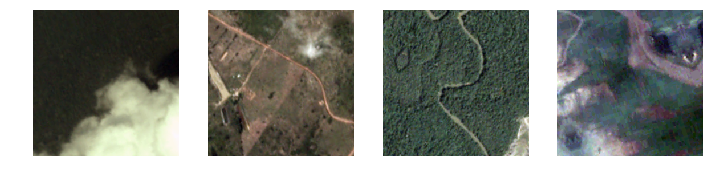

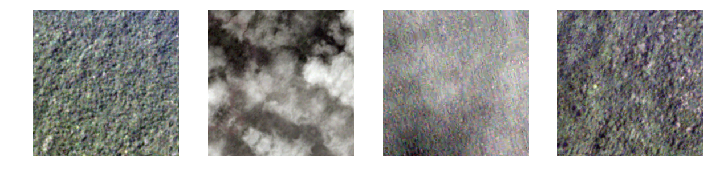

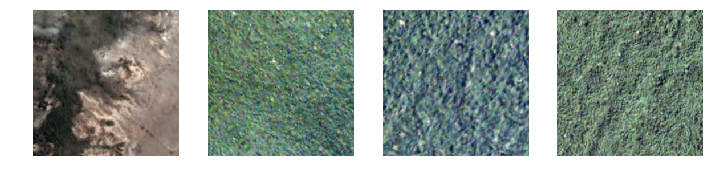

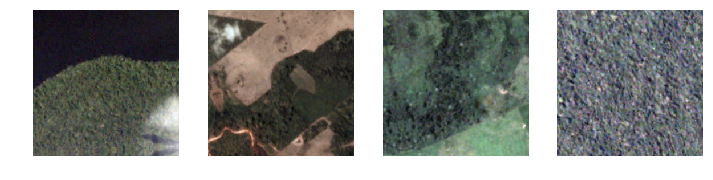

In [98]:
loop_max_counter = 1
for x, y_true, info in val_flow:
        
    y_pred = cnn.predict(x, batch_size=x.shape[0])
    n = 4
    for counter in range(params['batch_size']):
        print("\n--", info[counter])
        print('y_true: ', y_true[counter, :])
        print('y_pred: ', y_pred[counter, :])        
        if counter % n == 0:
            plt.figure(figsize=(12, 4))
        plt.subplot(1, n, counter % n + 1)
        if channels_first:
            img = x[counter, :, :, :].transpose([1, 2, 0])
        else:
            img = x[counter, :, :, :]
        plt.imshow(scale_percentile(img, q_min=0.0, q_max=100.0))
#         plt.imshow(img)        
        plt.axis('off')
    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break
    

## Predict tags on test data

In [31]:
from data_utils import test_jpg_ids, test_jpg_files
from test_utils import classification_predict as predict

In [32]:
test_id_type_list = []
for image_id in test_jpg_ids:
    test_id_type_list.append((image_id, "Test_jpg"))

print(len(test_id_type_list))

40669


In [33]:
n_folds = 5
predictions = []
run_counter = 0
n_runs = 2

In [34]:
while run_counter < n_runs:
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)

    # SqueezeNet on 5 folds
    for val_fold_index in range(n_folds):
                
        val_fold_index += 1
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
        
        cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'])
        params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)
        print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))        

        weights_files = glob(os.path.join(OUTPUT_PATH, "weights", "%s*.h5" % params['save_prefix']))
        assert len(weights_files) > 0, "Failed to load weights"
        best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        cnn.load_weights(best_weights_filename)
        
        params['seed'] += run_counter
        df = predict(cnn, test_id_type_list, **params)
        predictions.append(df)
 



 ---- New run :  1 / 2


 ---- Validation fold index:  1 / 5

 2017-07-05 01:42:16.912956 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=0_seed=2017_04_val_loss=9.4452_val_precision=0.2647_val_recall=0.6062.h5 9.4452
-- 0 / 64
-- 16 / 64
-- 32 / 64
-- 48 / 64


 ---- Validation fold index:  2 / 5

 2017-07-05 01:42:25.161256 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=1_seed=2017_03_val_loss=10.2769_val_precision=0.1780_val_recall=0.5460.h5 10.2769
-- 0 / 64
-- 16 / 64
-- 32 / 64
-- 48 / 64


 ---- Validation fold index:  3 / 5

 2017-07-05 01:42:32.715950 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet2_all_classes_fold=2_seed=2017_04_val_loss=7.9261_val_precision=0.2197_val

In [35]:
import pandas as pd

def compute_mean(predictions):
    df = predictions[0]
    for p in predictions[1:]:
        df = pd.concat([df, p], axis=0)
    df = df.apply(pd.to_numeric, errors='ignore')
    gb = df.groupby('image_name')
    df2 = gb.agg(np.mean).reset_index()
    return df2

In [39]:
df = compute_mean(predictions)

# info = 'mean_cv=6_squeezenet'
# now = datetime.now()
# sub_file = 'submission_' + info + '.csv'
# sub_file = os.path.join('results', sub_file)
# df.to_csv(sub_file, index=False)

In [37]:
predictions[0].head()

,image_name,slash_burn,artisinal_mine,habitation,selective_logging,clear,cultivation,water,partly_cloudy,bare_ground,blooming,agriculture,blow_down,conventional_mine,cloudy,primary,haze,road
0,10009.jpg,0.506258,0.562097,0.975057,0.001368,0.049075,0.002451,0.961137,0.661215,0.000105,0.000004,0.990789,0.010330,0.047737,0.033023,0.900089,0.055774,0.597479
1,10013.jpg,0.112824,0.992581,0.665956,0.022905,0.252470,0.002009,0.758580,0.047629,0.030355,0.000051,0.956831,0.045855,0.181108,0.420796,0.425628,0.548716,0.586713
2,10026.jpg,0.683666,0.770768,0.754240,0.005178,0.920248,0.004585,0.557355,0.951823,0.004545,0.000106,0.952081,0.383490,0.100664,0.102589,0.763708,0.336883,0.314157
3,10051.jpg,0.558847,0.923822,0.997724,0.000904,0.736889,0.000934,0.987514,0.774715,0.053452,0.000031,0.848869,0.003037,0.161278,0.065336,0.836500,0.738170,0.758234
4,10050.jpg,0.001674,0.981961,0.694869,0.227738,0.220498,0.000028,0.957476,0.531832,0.078176,0.000003,0.985369,0.361313,0.019534,0.050918,0.999852,0.002664,0.004680


In [38]:
predictions[1].head()

,image_name,slash_burn,artisinal_mine,habitation,selective_logging,clear,cultivation,water,partly_cloudy,bare_ground,blooming,agriculture,blow_down,conventional_mine,cloudy,primary,haze,road
0,10009.jpg,0.465652,0.030405,0.269544,0.409754,0.857248,0.025975,0.999920,0.051838,0.066960,0.978959,0.883892,0.873516,0.995550,0.026185,0.462543,0.000612,0.000681
1,10039.jpg,0.093729,0.006439,0.759044,0.983510,0.221559,0.087380,0.889295,0.521726,0.998706,0.915714,0.597018,0.769996,0.985642,0.762664,0.908943,0.003693,0.121895
2,10036.jpg,0.561332,0.621638,0.481471,0.177879,0.391414,0.203498,0.980438,0.157688,0.990710,0.993740,0.612709,0.829291,0.997904,0.583979,0.812165,0.000005,0.095353
3,10026.jpg,0.062532,0.030563,0.024138,0.176282,0.614454,0.046622,0.992656,0.032808,0.879304,0.937467,0.414737,0.823702,0.973572,0.532634,0.751906,0.001167,0.028366
4,10011.jpg,0.099131,0.705599,0.583571,0.962048,0.500123,0.025582,0.957145,0.117518,0.997569,0.984932,0.130966,0.229523,0.986412,0.920123,0.739398,0.005017,0.341393


In [40]:
df.head()

,image_name,slash_burn,artisinal_mine,habitation,selective_logging,clear,cultivation,water,partly_cloudy,bare_ground,blooming,agriculture,blow_down,conventional_mine,cloudy,primary,haze,road
0,0.jpg,0.547587,0.394494,0.748083,0.417404,0.759704,0.189018,0.661740,0.350495,0.622014,0.384360,0.663181,0.509230,0.511590,0.385018,0.720199,0.288789,0.478163
1,1.jpg,0.418558,0.205205,0.738539,0.296904,0.546367,0.327220,0.582137,0.311244,0.478286,0.582767,0.810059,0.641347,0.475419,0.401459,0.787750,0.096000,0.614872
2,10.jpg,0.519530,0.400793,0.584262,0.434872,0.489117,0.170434,0.582213,0.592595,0.593682,0.410522,0.551644,0.484007,0.575560,0.538420,0.883766,0.204803,0.673564
3,100.jpg,0.289584,0.456127,0.891757,0.353185,0.745096,0.119059,0.717935,0.476995,0.553315,0.433153,0.844619,0.636376,0.686859,0.390396,0.892342,0.350472,0.409009
4,1000.jpg,0.481877,0.281683,0.754391,0.282936,0.650377,0.148259,0.534274,0.453858,0.638972,0.476578,0.444342,0.567461,0.597796,0.410205,0.700519,0.346194,0.288687


In [58]:
import h5py

weights_files = glob(os.path.join(OUTPUT_PATH, "weights", "%s*.h5" % params['save_prefix']))
assert len(weights_files) > 0, "Failed to load weights"
best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
print("Load best loss weights: ", best_weights_filename, best_val_loss)

filename = best_weights_filename
f = h5py.File(filename, 'r')

Load best loss weights:  D:\vfomin\MyExamples\python\planet_amazon_rainforest\output\weights\SqueezeNet2_all_classes_fold=0_seed=2017_37_val_loss=5.1085_val_precision=0.6895_val_recall=0.7962.h5 5.1085


In [59]:
f.visit(print)

conv1
conv1/conv1_1
conv1/conv1_1/bias:0
conv1/conv1_1/kernel:0
conv10_17
conv10_17/conv10_17_1
conv10_17/conv10_17_1/bias:0
conv10_17/conv10_17_1/kernel:0
dense_3
dense_3/dense_3
dense_3/dense_3/bias:0
dense_3/dense_3/kernel:0
dense_4
dense_4/dense_4
dense_4/dense_4/bias:0
dense_4/dense_4/kernel:0
drop9
fire2
fire2/concat
fire2/expand1x1
fire2/expand1x1/fire2
fire2/expand1x1/fire2/expand1x1_1
fire2/expand1x1/fire2/expand1x1_1/bias:0
fire2/expand1x1/fire2/expand1x1_1/kernel:0
fire2/expand3x3
fire2/expand3x3/fire2
fire2/expand3x3/fire2/expand3x3_1
fire2/expand3x3/fire2/expand3x3_1/bias:0
fire2/expand3x3/fire2/expand3x3_1/kernel:0
fire2/relu_expand1x1
fire2/relu_expand3x3
fire2/relu_squeeze1x1
fire2/squeeze1x1
fire2/squeeze1x1/fire2
fire2/squeeze1x1/fire2/squeeze1x1_1
fire2/squeeze1x1/fire2/squeeze1x1_1/bias:0
fire2/squeeze1x1/fire2/squeeze1x1_1/kernel:0
fire3
fire3/concat
fire3/expand1x1
fire3/expand1x1/fire3
fire3/expand1x1/fire3/expand1x1_1
fire3/expand1x1/fire3/expand1x1_1/bias:0
fir

In [91]:
d1_k = f['dense_3/dense_3/kernel:0']
d1_b = f['dense_3/dense_3/bias:0']
d2_b = f['dense_4/dense_4/bias:0']

In [70]:
d1_k.value

array([[-0.0287113 , -0.03866413, -0.02991811, ..., -0.0163001 ,
         0.01647011,  0.03349068],
       [ 0.02606682, -0.01456664, -0.02498982, ..., -0.03487982,
        -0.00589896, -0.03041815],
       [ 0.03761434,  0.03029052,  0.03036643, ..., -0.03123344,
         0.00343812,  0.0123884 ],
       ..., 
       [-0.01210862, -0.00139377, -0.01365963, ..., -0.00159778,
         0.00454122, -0.01218032],
       [ 0.02257548,  0.00423508,  0.03205475, ..., -0.00509317,
         0.02718033,  0.03510071],
       [ 0.02157245,  0.01878551,  0.00546611, ..., -0.00041584,
         0.01339003, -0.03982717]], dtype=float32)